In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import copy
from IPython.display import clear_output
import pandas as pd

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

class PDWorld: # We initialize the PD-World environment
    def __init__(self, grid_size=5, pickup_locs=[(3,5), (4,2)], dropoff_locs=[(1,1), (1,5), (3,3), (5,5)], agent_f_pos=(1,3), agent_m_pos=(5,3)):
        self.grid_size = grid_size
        self.pickup_locs = pickup_locs
        self.dropoff_locs = dropoff_locs

        self.pickup_blocks = {loc: 10 for loc in pickup_locs} # Each pickup location starts with 10 blocks

        self.dropoff_blocks = {loc: 0 for loc in dropoff_locs}

        self.agent_f_pos = agent_f_pos
        self.agent_m_pos = agent_m_pos

        self.agent_f_holding = False
        self.agent_m_holding = False

        self.initial_pickup_locs = copy.deepcopy(pickup_locs)
        self.initial_agent_f_pos = agent_f_pos
        self.initial_agent_m_pos = agent_m_pos

    def reset(self, keep_qtable=True): # We reset the world but keep q-tables
        self.pickup_blocks = {loc: 10 for loc in self.pickup_locs}
        self.dropoff_blocks = {loc: 0 for loc in self.dropoff_locs}
        self.agent_f_pos = self.initial_agent_f_pos
        self.agent_m_pos = self.initial_agent_m_pos
        self.agent_f_holding = False
        self.agent_m_holding = False

    def is_terminal(self): # In this function we check if terminal state is reached, so all drop-off locations have 5 blocks
        return all(blocks == 5 for blocks in self.dropoff_blocks.values())

    def get_state(self, agent='F'): # This is where we return the current state for a given agent
        if agent == 'F':
            return (self.agent_f_pos, self.agent_f_holding, self.agent_m_pos)
        else:
            return (self.agent_m_pos, self.agent_m_holding, self.agent_f_pos)

    def get_valid_actions(self, agent='F'): # This function returns the valid actions for a given agent

        actions = []
        pos = self.agent_f_pos if agent == 'F' else self.agent_m_pos
        other_pos = self.agent_m_pos if agent == 'F' else self.agent_f_pos
        holding = self.agent_f_holding if agent == 'F' else self.agent_m_holding


        if pos[0] > 1 and (pos[0]-1, pos[1]) != other_pos:
            actions.append('N')
        if pos[0] < self.grid_size and (pos[0]+1, pos[1]) != other_pos:
            actions.append('S')
        if pos[1] < self.grid_size and (pos[0], pos[1]+1) != other_pos:
            actions.append('E')
        if pos[1] > 1 and (pos[0], pos[1]-1) != other_pos:
            actions.append('W')

        if not holding and pos in self.pickup_locs and self.pickup_blocks.get(pos, 0) > 0:
            actions.append('P')

        if holding and pos in self.dropoff_locs and self.dropoff_blocks.get(pos, 0) < 5:
            actions.append('D')

        return actions

    def execute_action(self, agent, action): # We execute a selected action
        if agent == 'F':
            pos = self.agent_f_pos
            holding = self.agent_f_holding
        else:
            pos = self.agent_m_pos
            holding = self.agent_m_holding

        reward = -1

        if action == 'N':
            new_pos = (pos[0]-1, pos[1])
        elif action == 'S':
            new_pos = (pos[0]+1, pos[1])
        elif action == 'E':
            new_pos = (pos[0], pos[1]+1)
        elif action == 'W':
            new_pos = (pos[0], pos[1]-1)
        elif action == 'P':
            if pos in self.pickup_locs and self.pickup_blocks[pos] > 0:
                self.pickup_blocks[pos] -= 1
                if agent == 'F':
                    self.agent_f_holding = True
                else:
                    self.agent_m_holding = True
                reward = 13
            new_pos = pos
        elif action == 'D':
            if pos in self.dropoff_locs and self.dropoff_blocks[pos] < 5:
                self.dropoff_blocks[pos] += 1
                if agent == 'F':
                    self.agent_f_holding = False
                else:
                    self.agent_m_holding = False
                reward = 13
            new_pos = pos
        else:
            new_pos = pos

        if agent == 'F':
            self.agent_f_pos = new_pos
        else:
            self.agent_m_pos = new_pos

        return reward

    def visualize(self): # This function visualizes the current state of our world
        grid = np.zeros((self.grid_size, self.grid_size))

        for loc in self.pickup_locs:
            if self.pickup_blocks.get(loc, 0) > 0:
                grid[loc[0]-1, loc[1]-1] = 1


        for loc in self.dropoff_locs:
            grid[loc[0]-1, loc[1]-1] = 2

        grid[self.agent_f_pos[0]-1, self.agent_f_pos[1]-1] = 3
        grid[self.agent_m_pos[0]-1, self.agent_m_pos[1]-1] = 4

        plt.figure(figsize=(6, 6))
        plt.imshow(grid, cmap='Set3')
        plt.title('PD-World State')
        plt.colorbar(ticks=[0, 1, 2, 3, 4], label='0:Empty, 1:Pickup, 2:Dropoff, 3:AgentF, 4:AgentM')
        plt.grid(True)
        plt.show()

class QLearningAgent: # This class implements our Q-Learning/Sarsa agent
    def __init__(self, agent_name, alpha=0.3, gamma=0.5, algorithm='Q-learning'):
        self.agent_name = agent_name
        self.alpha = alpha
        self.gamma = gamma
        self.algorithm = algorithm
        self.q_table = defaultdict(lambda: defaultdict(float)) # This is a nested dictionary for Q-values: state(which is a tuple) -> action -> Q-value

    def get_q_value(self, state, action):
        return self.q_table[state][action]

    def choose_action(self, state, valid_actions, policy='PRANDOM'): # This function allows us to choose an action based on the selected policy

        if not valid_actions:
            return None


        if 'P' in valid_actions or 'D' in valid_actions:
            if 'P' in valid_actions:
                return 'P'
            if 'D' in valid_actions:
                return 'D'

        if policy == 'PRANDOM':
            return random.choice(valid_actions)

        elif policy == 'PGREEDY':
            q_values = {action: self.get_q_value(state, action) for action in valid_actions}
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            return random.choice(best_actions)

        elif policy == 'PEXPLOIT':
            if random.random() < 0.8:
                q_values = {action: self.get_q_value(state, action) for action in valid_actions}
                max_q = max(q_values.values())
                best_actions = [action for action, q in q_values.items() if q == max_q]
                return random.choice(best_actions)
            else:
                return random.choice(valid_actions)

    def update_q_value(self, state, action, reward, next_state, next_action, valid_next_actions): # This function updates the Q-values based on the selected algorithm
        current_q = self.get_q_value(state, action)

        if self.algorithm == 'Q-learning':
            if valid_next_actions:
                max_next_q = max([self.get_q_value(next_state, a) for a in valid_next_actions])
            else:
                max_next_q = 0
            new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)

        else: # SARSA algorithm
            if next_action:
                next_q = self.get_q_value(next_state, next_action)
            else:
                next_q = 0
            new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)

        self.q_table[state][action] = new_q


ACTIONS = ['N','S','E','W','P','D']

def qtable_to_matrix(qtable, drop_PD=True): # This function creates our Q-table in a matrix format
    cols = ACTIONS if not drop_PD else ['N','S','E','W']
    rows = []

    for state, actmap in qtable.items():
        row = {'state': str(state)}
        for a in cols:
            row[a] = actmap.get(a, 0.0)
        rows.append(row)

    df = pd.DataFrame(rows)
    if rows:
        df = df[['state'] + cols]

    return df

def snapshot_qtables(agent_f, agent_m, tag, drop_PD=True, save_prefix=None):

    dfF = qtable_to_matrix(agent_f.q_table, drop_PD=drop_PD)
    dfM = qtable_to_matrix(agent_m.q_table, drop_PD=drop_PD)

    if save_prefix:
        dfF.to_csv(f"{save_prefix}_AgentF_{tag}.csv", index=False)
        dfM.to_csv(f"{save_prefix}_AgentM_{tag}.csv", index=False)
        print(f"Saved Q-table snapshots: {save_prefix}_AgentF_{tag}.csv  |  {save_prefix}_AgentM_{tag}.csv")

    return {'F': dfF, 'M': dfM}

def any_dropoff_reached_5(world):
    return any(v >= 5 for v in world.dropoff_blocks.values())


def run_experiment(world, agent_f, agent_m, total_steps, policy_schedule, experiment_name, pickup_change_config=None, seed=42): # This is the function we use to run our experiments
    set_seed(seed)
    # An episode consists of both agents taking actions until a terminal state is reached
    rewards_history = []
    steps_per_episode = []
    total_rewards_per_episode = []
    agent_distance_per_episode = []
    dist_sum = 0
    dist_count = 0
    terminal_count = 0
    current_step = 0
    episode_steps = 0
    episode_reward = 0

    first_dropoff_filled_captured = False
    first_terminal_captured = False
    qtable_snapshots = {}

    current_policy = policy_schedule[0][1] # Initialize the current policy
    policy_idx = 0

    print(f"Running {experiment_name} (Seed: {seed})")

    while current_step < total_steps:

        if world.is_terminal():
            terminal_count += 1
            steps_per_episode.append(episode_steps)
            total_rewards_per_episode.append(episode_reward)

            if dist_count > 0:
                agent_distance_per_episode.append(dist_sum / dist_count)
            else:
                agent_distance_per_episode.append(0)

            if not first_terminal_captured:
                qtable_snapshots['first_terminal'] = snapshot_qtables(agent_f, agent_m, tag=f"{experiment_name}_first_terminal", drop_PD=True, save_prefix=experiment_name.replace(" ","_"))
                first_terminal_captured = True

            print(f"Terminal state {terminal_count} reached at step {current_step}")
            print(f"Episode steps: {episode_steps}, Episode reward: {episode_reward}")

            if pickup_change_config and terminal_count == pickup_change_config[0]: # This would only be relevant for Experiment 4
                world.pickup_locs = pickup_change_config[1]
                print(f"Pickup locations changed to: {world.pickup_locs}")

            world.reset()
            episode_steps = 0
            episode_reward = 0
            dist_sum = 0
            dist_count = 0

        if policy_idx + 1 < len(policy_schedule) and current_step >= policy_schedule[policy_idx + 1][0]: # Change policy if needed, like after 500 steps
            policy_idx += 1
            current_policy = policy_schedule[policy_idx][1]
            print(f"\nSwitching to policy {current_policy} at step {current_step}")

        state_f = world.get_state('F')
        valid_actions_f = world.get_valid_actions('F')

        if valid_actions_f:
            action_f = agent_f.choose_action(state_f, valid_actions_f, current_policy)
            reward_f = world.execute_action('F', action_f)

            next_state_f = world.get_state('F')
            next_valid_actions_f = world.get_valid_actions('F')
            next_action_f = agent_f.choose_action(next_state_f, next_valid_actions_f, current_policy) if next_valid_actions_f else None

            agent_f.update_q_value(state_f, action_f, reward_f, next_state_f, next_action_f, next_valid_actions_f)

            episode_reward += reward_f
            rewards_history.append(reward_f)

            if not first_dropoff_filled_captured and any_dropoff_reached_5(world):
                qtable_snapshots['first_dropoff_5'] = snapshot_qtables(agent_f, agent_m, tag=f"{experiment_name}_first_dropoff5", drop_PD=True, save_prefix=experiment_name.replace(" ","_"))
                first_dropoff_filled_captured = True

        dist_sum += calculate_manhattan_distance(world.agent_f_pos, world.agent_m_pos)
        dist_count += 1
        
        current_step += 1
        episode_steps += 1

        if current_step >= total_steps:
            break

        state_m = world.get_state('M')
        valid_actions_m = world.get_valid_actions('M')

        if valid_actions_m: # Female goes first, then male
            action_m = agent_m.choose_action(state_m, valid_actions_m, current_policy)
            reward_m = world.execute_action('M', action_m)
            next_state_m = world.get_state('M')
            next_valid_actions_m = world.get_valid_actions('M')
            next_action_m = agent_m.choose_action(next_state_m, next_valid_actions_m, current_policy) if next_valid_actions_m else None

            agent_m.update_q_value(state_m, action_m, reward_m, next_state_m, next_action_m, next_valid_actions_m)

            episode_reward += reward_m
            rewards_history.append(reward_m)

            if not first_dropoff_filled_captured and any_dropoff_reached_5(world):
                qtable_snapshots['first_dropoff_5'] = snapshot_qtables(agent_f, agent_m, tag=f"{experiment_name}_first_dropoff5", drop_PD=True, save_prefix=experiment_name.replace(" ","_"))
                first_dropoff_filled_captured = True


        dist_sum += calculate_manhattan_distance(world.agent_f_pos, world.agent_m_pos)
        dist_count += 1

        current_step += 1
        episode_steps += 1

        if current_step % 1000 == 0:
            print(f"Step {current_step}/{total_steps} - Terminals: {terminal_count}")
            print("\n")

    if episode_steps > 0:
        steps_per_episode.append(episode_steps)
        total_rewards_per_episode.append(episode_reward)
        if dist_count > 0:
            agent_distance_per_episode.append(dist_sum / dist_count)
        else:
            agent_distance_per_episode.append(0)

    qtable_snapshots['final'] = snapshot_qtables(agent_f, agent_m, tag=f"{experiment_name}_final",drop_PD=True, save_prefix=experiment_name.replace(" ","_"))

    print(f"\nExperiment completed:")
    print(f"Total terminal states reached: {terminal_count}")
    print(f"Average steps per episode: {np.mean(steps_per_episode) if steps_per_episode else 0:.2f}")
    print(f"Average reward per episode: {np.mean(total_rewards_per_episode) if total_rewards_per_episode else 0:.2f}")
    print(f"Average agent distance per episode: {np.mean(agent_distance_per_episode) if agent_distance_per_episode else 0:.2f}")

    return {
        'rewards_history': rewards_history,
        'steps_per_episode': steps_per_episode,
        'total_rewards_per_episode': total_rewards_per_episode,
        'agent_distance_per_episode': agent_distance_per_episode,
        'mean_agent_distance': np.mean(agent_distance_per_episode) if agent_distance_per_episode else 0,
        'terminal_count': terminal_count,
        'agent_f_qtable': dict(agent_f.q_table),
        'agent_m_qtable': dict(agent_m.q_table),
        'qtable_snapshots': qtable_snapshots
    }

def plot_results(results, title): # This function plots the results of our experiments, some more visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    cumulative_rewards = np.cumsum(results['rewards_history'])
    axes[0, 0].plot(cumulative_rewards)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Cumulative Reward')
    axes[0, 0].set_title('Cumulative Rewards Over Time')

    axes[0, 0].grid(True)

    if results['total_rewards_per_episode']:

        axes[0, 1].plot(results['total_rewards_per_episode'])
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Total Reward')
        axes[0, 1].set_title('Total Rewards Per Episode')

        axes[0, 1].grid(True)

    if results['steps_per_episode']:
        axes[1, 0].plot(results['steps_per_episode'])
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Steps')
        axes[1, 0].set_title('Steps Per Episode')

        axes[1, 0].grid(True)

    window = 100
    if len(results['rewards_history']) >= window:
        moving_avg = np.convolve(results['rewards_history'], np.ones(window)/window, mode='valid')

        axes[1, 1].plot(moving_avg)
        axes[1, 1].set_xlabel('Step')
        axes[1, 1].set_ylabel('Average Reward')
        axes[1, 1].set_title(f'Moving Average Reward (window={window})')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def print_qtable_sample(qtable, agent_name, num_states=10):
    print(f"{agent_name} Q-Table Sample (first {num_states} states):")

    for i, (state, actions) in enumerate(list(qtable.items())[:num_states]):
        print(f"\nState {i+1}: {state}")
        for action, q_value in actions.items():
            print(f"  Action {action}: {q_value:.4f}")

def calculate_manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

Experiment 1a: PRANDOM for all 8000 steps
Running Experiment 1a (Seed: 42)
Saved Q-table snapshots: Experiment_1a_AgentF_Experiment 1a_first_dropoff5.csv  |  Experiment_1a_AgentM_Experiment 1a_first_dropoff5.csv
Saved Q-table snapshots: Experiment_1a_AgentF_Experiment 1a_first_terminal.csv  |  Experiment_1a_AgentM_Experiment 1a_first_terminal.csv
Terminal state 1 reached at step 740
Episode steps: 740, Episode reward: -180
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1680
Episode steps: 940, Episode reward: -380
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2500
Episode steps: 820, Episode reward: -260
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3052
Episode steps: 552, Episode reward: 8
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4640
Episode steps: 1588, Episode reward: -1028
Step 5000/8000 - Terminals: 5


Terminal state 6 reached at step 5548
Episode steps: 908, Episode reward: -348
Step 6000/8000 - Te

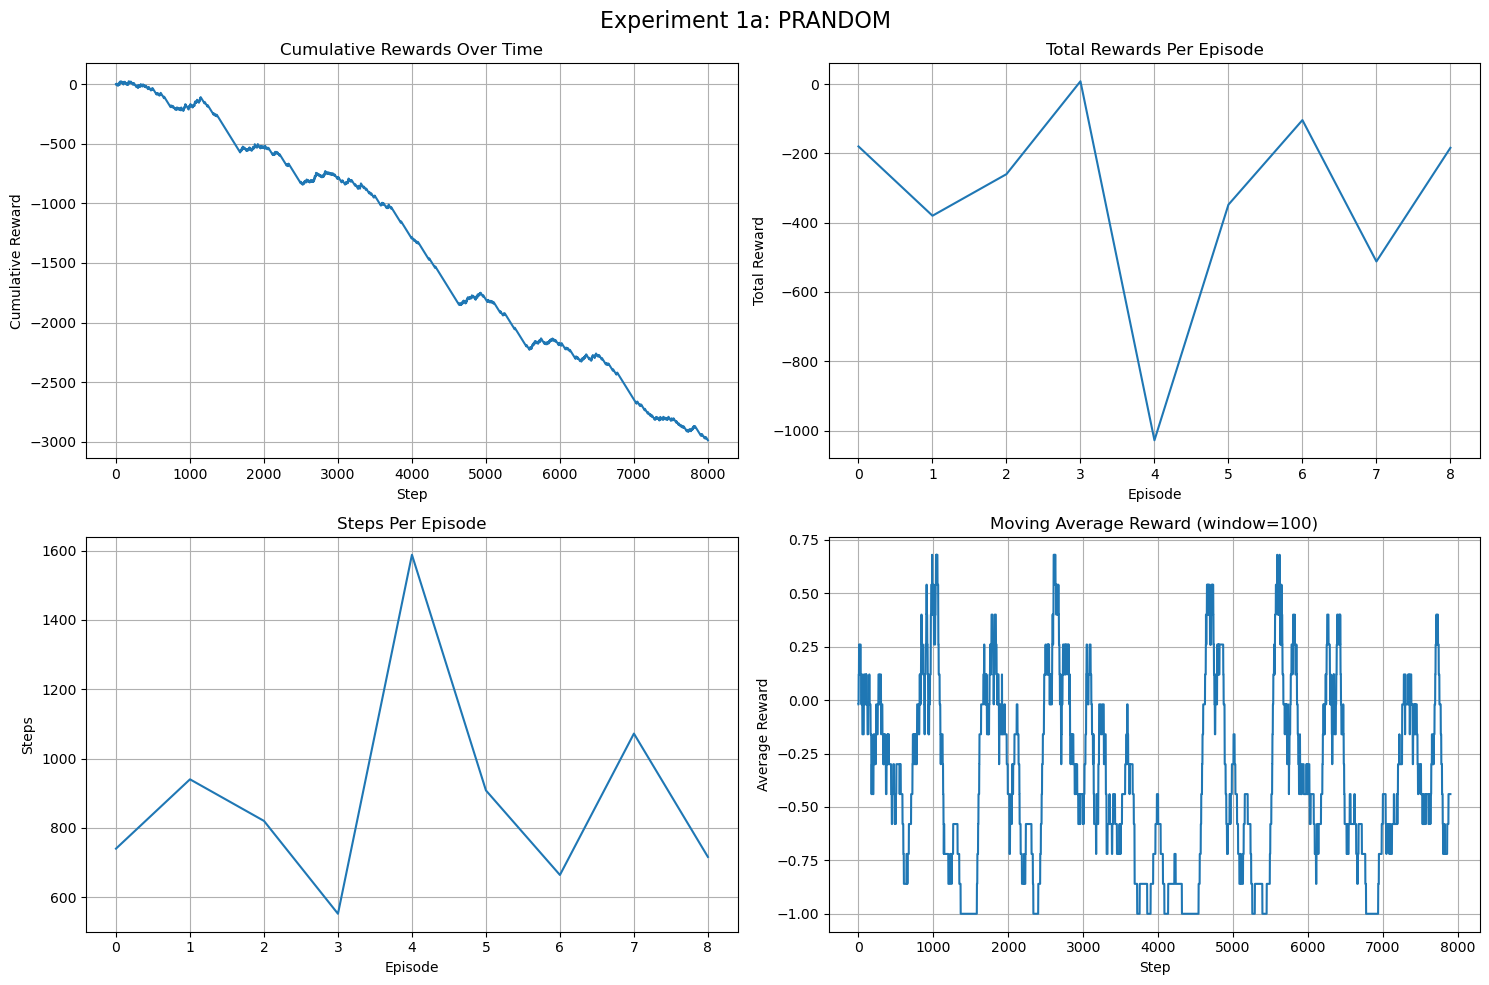

In [24]:
print("Experiment 1a: PRANDOM for all 8000 steps")

world_1a = PDWorld()
agent_f_1a = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1a = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')

policy_schedule_1a = [(0, 'PRANDOM')]
results_1a = run_experiment(world_1a, agent_f_1a, agent_m_1a, 8000, policy_schedule_1a, "Experiment 1a", seed=42)
plot_results(results_1a, "Experiment 1a: PRANDOM")

Experiment 1b: PRANDOM (500 steps) then PGREEDY (7500 steps)
Running Experiment 1b (Seed: 42)
Saved Q-table snapshots: Experiment_1b_AgentF_Experiment 1b_first_dropoff5.csv  |  Experiment_1b_AgentM_Experiment 1b_first_dropoff5.csv

Switching to policy PGREEDY at step 500
Saved Q-table snapshots: Experiment_1b_AgentF_Experiment 1b_first_terminal.csv  |  Experiment_1b_AgentM_Experiment 1b_first_terminal.csv
Terminal state 1 reached at step 896
Episode steps: 896, Episode reward: -336
Step 1000/8000 - Terminals: 1


Step 2000/8000 - Terminals: 1


Terminal state 2 reached at step 2156
Episode steps: 1260, Episode reward: -700
Step 3000/8000 - Terminals: 2


Terminal state 3 reached at step 3068
Episode steps: 912, Episode reward: -352
Terminal state 4 reached at step 3856
Episode steps: 788, Episode reward: -228
Step 4000/8000 - Terminals: 4


Step 5000/8000 - Terminals: 4


Terminal state 5 reached at step 5008
Episode steps: 1152, Episode reward: -592
Terminal state 6 reached at step 56

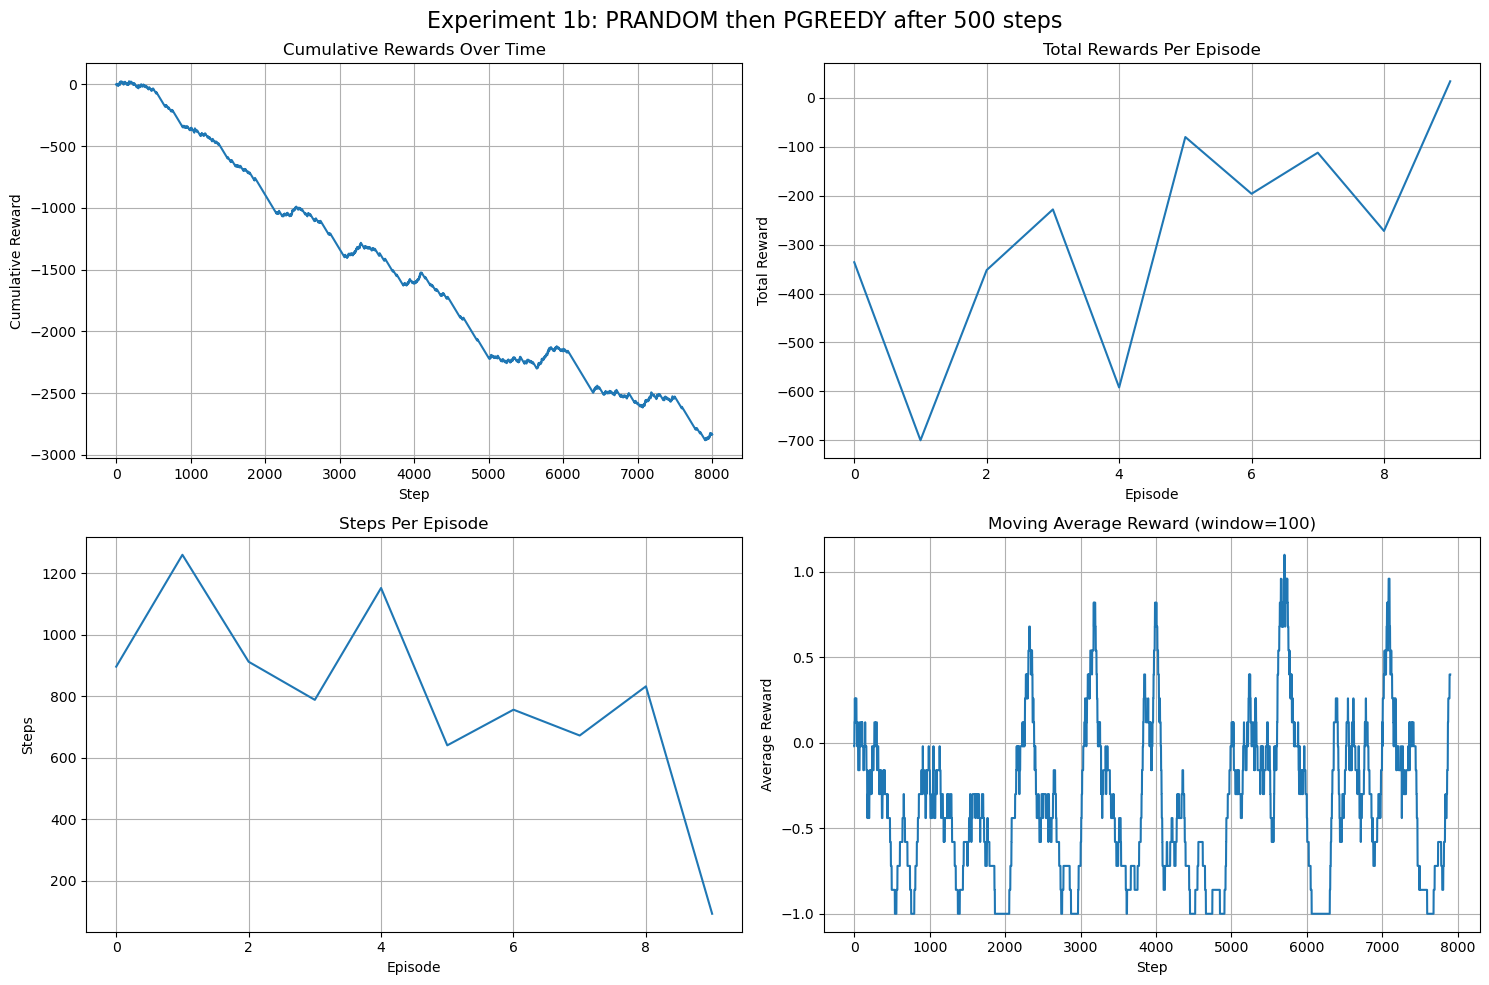

In [25]:
print("Experiment 1b: PRANDOM (500 steps) then PGREEDY (7500 steps)")


world_1b = PDWorld()
agent_f_1b = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1b = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')

policy_schedule_1b = [(0, 'PRANDOM'), (500, 'PGREEDY')]
results_1b = run_experiment(world_1b, agent_f_1b, agent_m_1b, 8000, policy_schedule_1b, "Experiment 1b", seed=42)
plot_results(results_1b, "Experiment 1b: PRANDOM then PGREEDY after 500 steps")

Experiment 1c: PRANDOM (500 steps) then PEXPLOIT (7500 steps)
Running Experiment 1c (Seed: 42)
Saved Q-table snapshots: Experiment_1c_AgentF_Experiment 1c_first_dropoff5.csv  |  Experiment_1c_AgentM_Experiment 1c_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_1c_AgentF_Experiment 1c_first_terminal.csv  |  Experiment_1c_AgentM_Experiment 1c_first_terminal.csv
Terminal state 1 reached at step 796
Episode steps: 796, Episode reward: -236
Step 1000/8000 - Terminals: 1


Step 2000/8000 - Terminals: 1


Terminal state 2 reached at step 2104
Episode steps: 1308, Episode reward: -748
Step 3000/8000 - Terminals: 2


Terminal state 3 reached at step 3360
Episode steps: 1256, Episode reward: -696
Step 4000/8000 - Terminals: 3


Terminal state 4 reached at step 4168
Episode steps: 808, Episode reward: -248
Step 5000/8000 - Terminals: 4


Terminal state 5 reached at step 5064
Episode steps: 896, Episode reward: -336
Terminal state 6 reached at step 

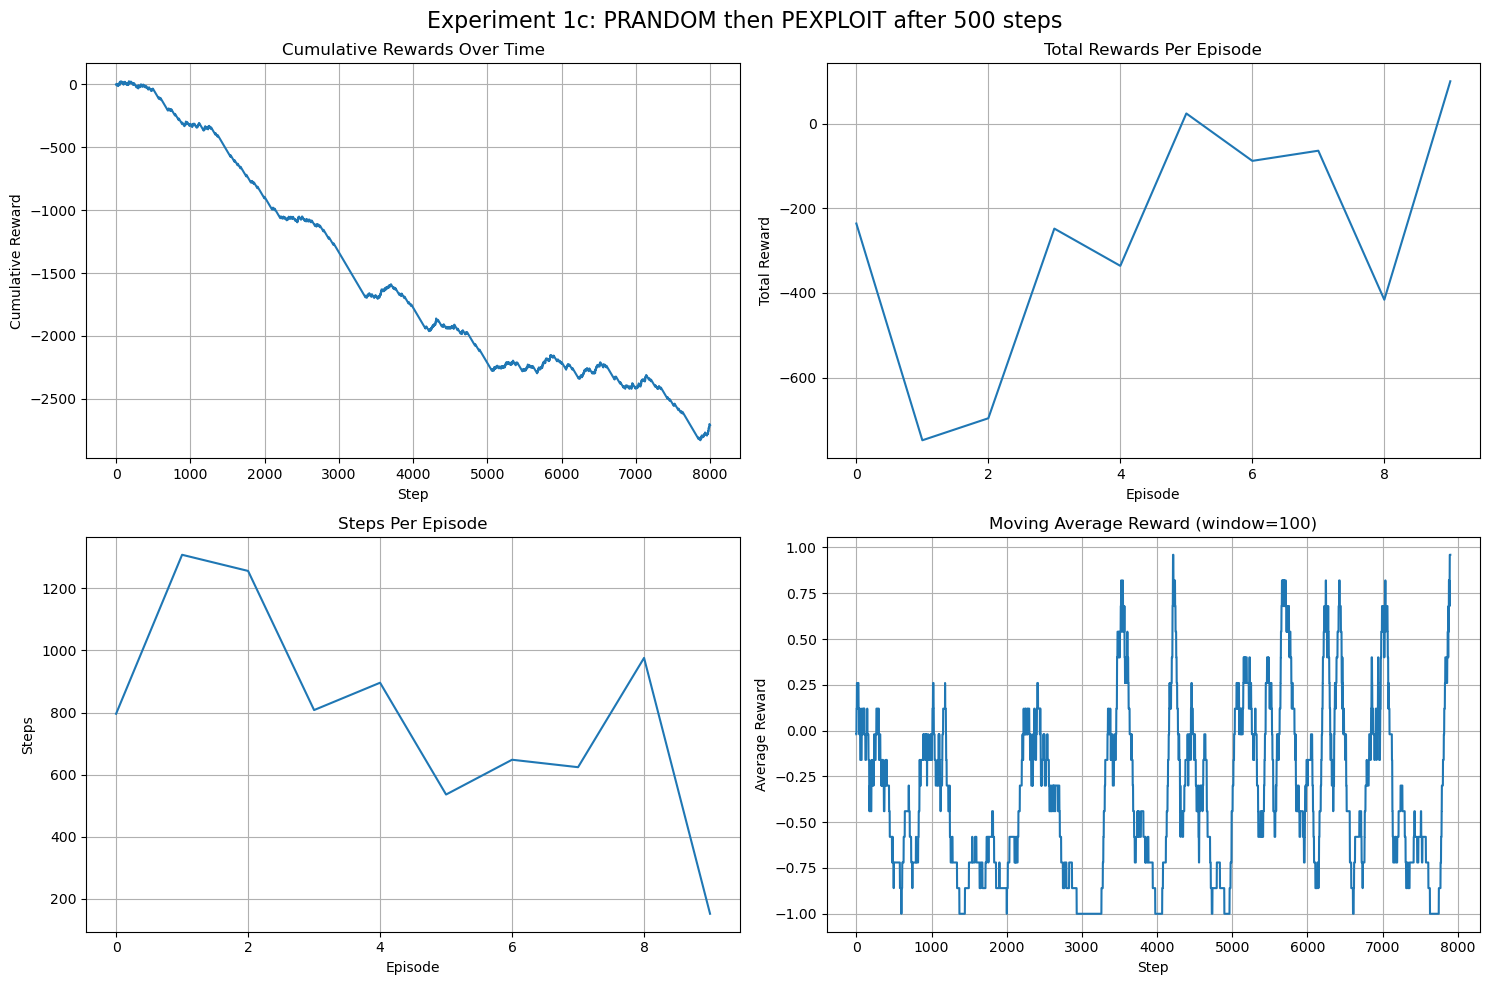

Agent F Q-Table Sample (first 10 states):

State 1: ((1, 3), False, (5, 3))
  Action W: -0.9620
  Action S: -0.9305
  Action E: -0.9963

State 2: ((1, 2), False, (5, 3))
  Action S: -0.5100
  Action E: -0.6400
  Action W: -0.5100

State 3: ((1, 2), False, (4, 3))
  Action S: -0.3000
  Action W: -0.5865
  Action E: -0.3765

State 4: ((2, 2), False, (4, 3))
  Action N: -0.6570
  Action S: -0.6570
  Action E: -0.5550
  Action W: -0.6570

State 5: ((2, 2), False, (5, 3))
  Action N: -0.3000
  Action S: -0.3000
  Action E: -0.5550
  Action W: 0.0000

State 6: ((1, 2), False, (5, 2))
  Action S: -0.3000
  Action E: -0.3000
  Action W: -0.6247

State 7: ((2, 2), False, (5, 2))
  Action N: -0.5550
  Action S: -0.5100
  Action E: -0.3450
  Action W: -0.5100

State 8: ((2, 2), False, (4, 2))
  Action N: -0.5865
  Action S: -0.3765
  Action E: -0.3450
  Action W: -0.3000

State 9: ((1, 2), False, (4, 2))
  Action S: -0.7020
  Action E: -0.5100
  Action W: -0.5550

State 10: ((2, 1), False, (5, 2)

In [26]:
print("Experiment 1c: PRANDOM (500 steps) then PEXPLOIT (7500 steps)")

world_1c = PDWorld()
agent_f_1c = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1c = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')

policy_schedule_1c = [(0, 'PRANDOM'), (500, 'PEXPLOIT')]
results_1c = run_experiment(world_1c, agent_f_1c, agent_m_1c, 8000, policy_schedule_1c, "Experiment 1c", seed=42)

plot_results(results_1c, "Experiment 1c: PRANDOM then PEXPLOIT after 500 steps")

print_qtable_sample(results_1c['agent_f_qtable'], "Agent F", num_states=10)

In [27]:
print("Coordination between agents in Exp. 1b and 1c:")
print(f"  Experiment 1b - Mean Agent Distance per Episode: {results_1b['mean_agent_distance']:.2f}")
print(f"  Experiment 1c - Mean Agent Distance per Episode: {results_1c['mean_agent_distance']:.2f}")

Coordination between agents in Exp. 1b and 1c:
  Experiment 1b - Mean Agent Distance per Episode: 3.22
  Experiment 1c - Mean Agent Distance per Episode: 3.22


In [28]:
print("Expiremtnt 1c Final Q-Table:")
snap_1c_final = results_1c['qtable_snapshots']['final']

print("\nFinal Q-Table (F):")
print(snap_1c_final['F'].head(12).to_string(index=False))

print("\nFinal Q-Table (M):")
print(snap_1c_final['M'].head(12).to_string(index=False))

Expiremtnt 1c Final Q-Table:

Final Q-Table (F):
                  state        N        S         E        W
((1, 3), False, (5, 3))  0.00000 -0.93048 -0.996336 -0.96198
((1, 2), False, (5, 3))  0.00000 -0.51000 -0.640050 -0.51000
((1, 2), False, (4, 3))  0.00000 -0.30000 -0.376500 -0.58650
((2, 2), False, (4, 3)) -0.65700 -0.65700 -0.555000 -0.65700
((2, 2), False, (5, 3)) -0.30000 -0.30000 -0.555000  0.00000
((1, 2), False, (5, 2))  0.00000 -0.30000 -0.300000 -0.62475
((2, 2), False, (5, 2)) -0.55500 -0.51000 -0.345000 -0.51000
((2, 2), False, (4, 2)) -0.58650 -0.37650 -0.345000 -0.30000
((1, 2), False, (4, 2))  0.00000 -0.70200 -0.510000 -0.55500
((2, 1), False, (5, 2)) -0.38325  0.00000 -0.300000  0.00000
((2, 1), False, (5, 3)) -0.51000 -0.51000 -0.657000  0.00000
((3, 1), False, (5, 3))  0.00000  0.00000 -0.586500  0.00000

Final Q-Table (M):
                  state        N       S       E       W
((5, 3), False, (1, 2)) -0.51000  0.0000 -0.6570 -0.5100
((4, 3), False, (1, 2)) 

Experiment 2: SARSA with PRANDOM (500 steps) then PEXPLOIT (7500 steps)
Running Experiment 2 (SARSA) (Seed: 42)
Saved Q-table snapshots: Experiment_2_(SARSA)_AgentF_Experiment 2 (SARSA)_first_dropoff5.csv  |  Experiment_2_(SARSA)_AgentM_Experiment 2 (SARSA)_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_2_(SARSA)_AgentF_Experiment 2 (SARSA)_first_terminal.csv  |  Experiment_2_(SARSA)_AgentM_Experiment 2 (SARSA)_first_terminal.csv
Terminal state 1 reached at step 796
Episode steps: 796, Episode reward: -236
Step 1000/8000 - Terminals: 1


Step 2000/8000 - Terminals: 1


Terminal state 2 reached at step 2104
Episode steps: 1308, Episode reward: -748
Step 3000/8000 - Terminals: 2


Terminal state 3 reached at step 3172
Episode steps: 1068, Episode reward: -508
Step 4000/8000 - Terminals: 3


Terminal state 4 reached at step 4404
Episode steps: 1232, Episode reward: -672
Step 5000/8000 - Terminals: 4


Terminal state 5 reached at step 5096


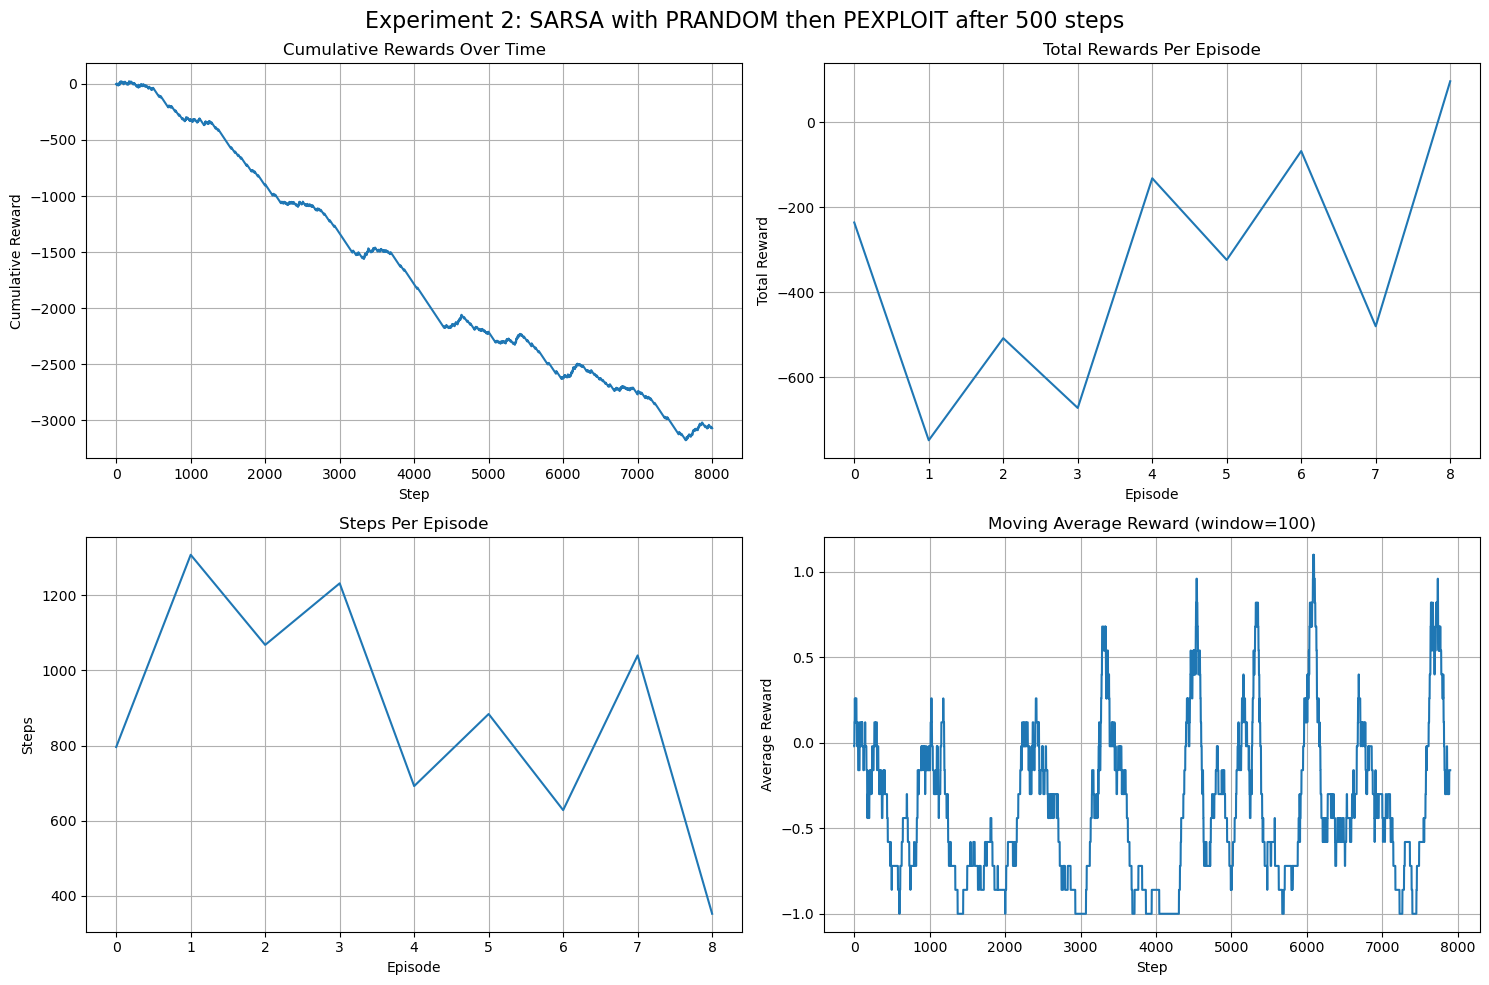

Agent F Q-Table Sample (first 10 states):

State 1: ((1, 3), False, (5, 3))
  Action W: -1.0065
  Action S: -0.8049
  Action E: -0.8049

State 2: ((1, 2), False, (5, 3))
  Action S: -0.3000
  Action W: -0.5550
  Action E: -0.6400

State 3: ((1, 2), False, (4, 3))
  Action S: -0.3000
  Action W: -0.3000
  Action E: -0.6247

State 4: ((2, 2), False, (4, 3))
  Action S: -0.5617
  Action E: -0.5550
  Action N: -0.5865
  Action W: -0.5100

State 5: ((2, 2), False, (5, 3))
  Action N: -0.3000
  Action S: -0.3000
  Action E: -0.3000
  Action W: 0.0000

State 6: ((1, 2), False, (5, 2))
  Action S: -0.3000
  Action E: -0.3450
  Action W: -0.3450

State 7: ((2, 2), False, (5, 2))
  Action W: -0.5617
  Action N: -0.5550
  Action S: -0.5100
  Action E: -0.5865

State 8: ((2, 2), False, (4, 2))
  Action N: -0.6240
  Action S: -0.3450
  Action E: -0.3765
  Action W: -0.6212

State 9: ((1, 2), False, (4, 2))
  Action S: -0.8203
  Action W: -0.7772
  Action E: -0.8837

State 10: ((2, 1), False, (5, 2)

In [29]:
print("Experiment 2: SARSA with PRANDOM (500 steps) then PEXPLOIT (7500 steps)")

world_2 = PDWorld()
agent_f_2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='SARSA')
agent_m_2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='SARSA')

policy_schedule_2 = [(0, 'PRANDOM'), (500, 'PEXPLOIT')]
results_2 = run_experiment(world_2, agent_f_2, agent_m_2, 8000, policy_schedule_2, "Experiment 2 (SARSA)", seed=42)
plot_results(results_2, "Experiment 2: SARSA with PRANDOM then PEXPLOIT after 500 steps")

print_qtable_sample(results_2['agent_f_qtable'], "Agent F", num_states=10)

In [30]:
snap_2 = results_2['qtable_snapshots']

print("\nQ-Table at first drop-off filled (F):")
print(snap_2['first_dropoff_5']['F'].head(12).to_string(index=False))
print("\nQ-Table at first drop-off filled (M):")
print(snap_2['first_dropoff_5']['M'].head(12).to_string(index=False))

print("\nQ-Table at first terminal (F):")
print(snap_2['first_terminal']['F'].head(12).to_string(index=False))
print("\nQ-Table at first terminal (M):")
print(snap_2['first_terminal']['M'].head(12).to_string(index=False))

print("\nFinal Q-Table (F):")
print(snap_2['final']['F'].head(12).to_string(index=False))
print("\nFinal Q-Table (M):")
print(snap_2['final']['M'].head(12).to_string(index=False))


Q-Table at first drop-off filled (F):
                  state    N      S    E    W
((1, 3), False, (5, 3))  0.0  0.000  0.0 -0.3
((1, 2), False, (5, 3))  0.0  0.000  0.0  0.0
((1, 2), False, (4, 3))  0.0 -0.300  0.0 -0.3
((2, 2), False, (4, 3))  0.0  0.000  0.0  0.0
((2, 2), False, (5, 3)) -0.3  0.000  0.0  0.0
((1, 2), False, (5, 2))  0.0 -0.300  0.0  0.0
((2, 2), False, (5, 2))  0.0  0.000  0.0 -0.3
((2, 2), False, (4, 2)) -0.3  0.000  0.0  0.0
((1, 2), False, (4, 2))  0.0 -0.345 -0.3 -0.3
((2, 1), False, (5, 2))  0.0  0.000  0.0  0.0
((2, 1), False, (5, 3))  0.0 -0.300  0.0  0.0
((3, 1), False, (5, 3))  0.0  0.000  0.0  0.0

Q-Table at first drop-off filled (M):
                  state      N    S    E    W
((5, 3), False, (1, 2)) -0.300  0.0  0.0 -0.3
((4, 3), False, (1, 2))  0.000  0.0  0.0  0.0
((4, 3), False, (2, 2))  0.000 -0.3  0.0  0.0
((5, 3), False, (2, 2)) -0.345  0.0 -0.3  0.0
((5, 2), False, (1, 2))  0.000  0.0  0.0  0.0
((5, 2), False, (2, 2)) -0.300  0.0  0.0  0.0
((

Experiment 3a: Q-learning with alpha=0.15
Running Experiment 3a (alpha=0.15) (Seed: 42)
Saved Q-table snapshots: Experiment_3a_(alpha=0.15)_AgentF_Experiment 3a (alpha=0.15)_first_dropoff5.csv  |  Experiment_3a_(alpha=0.15)_AgentM_Experiment 3a (alpha=0.15)_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_3a_(alpha=0.15)_AgentF_Experiment 3a (alpha=0.15)_first_terminal.csv  |  Experiment_3a_(alpha=0.15)_AgentM_Experiment 3a (alpha=0.15)_first_terminal.csv
Terminal state 1 reached at step 796
Episode steps: 796, Episode reward: -236
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1556
Episode steps: 760, Episode reward: -200
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2392
Episode steps: 836, Episode reward: -276
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3188
Episode steps: 796, Episode reward: -236
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4036
Episode ste

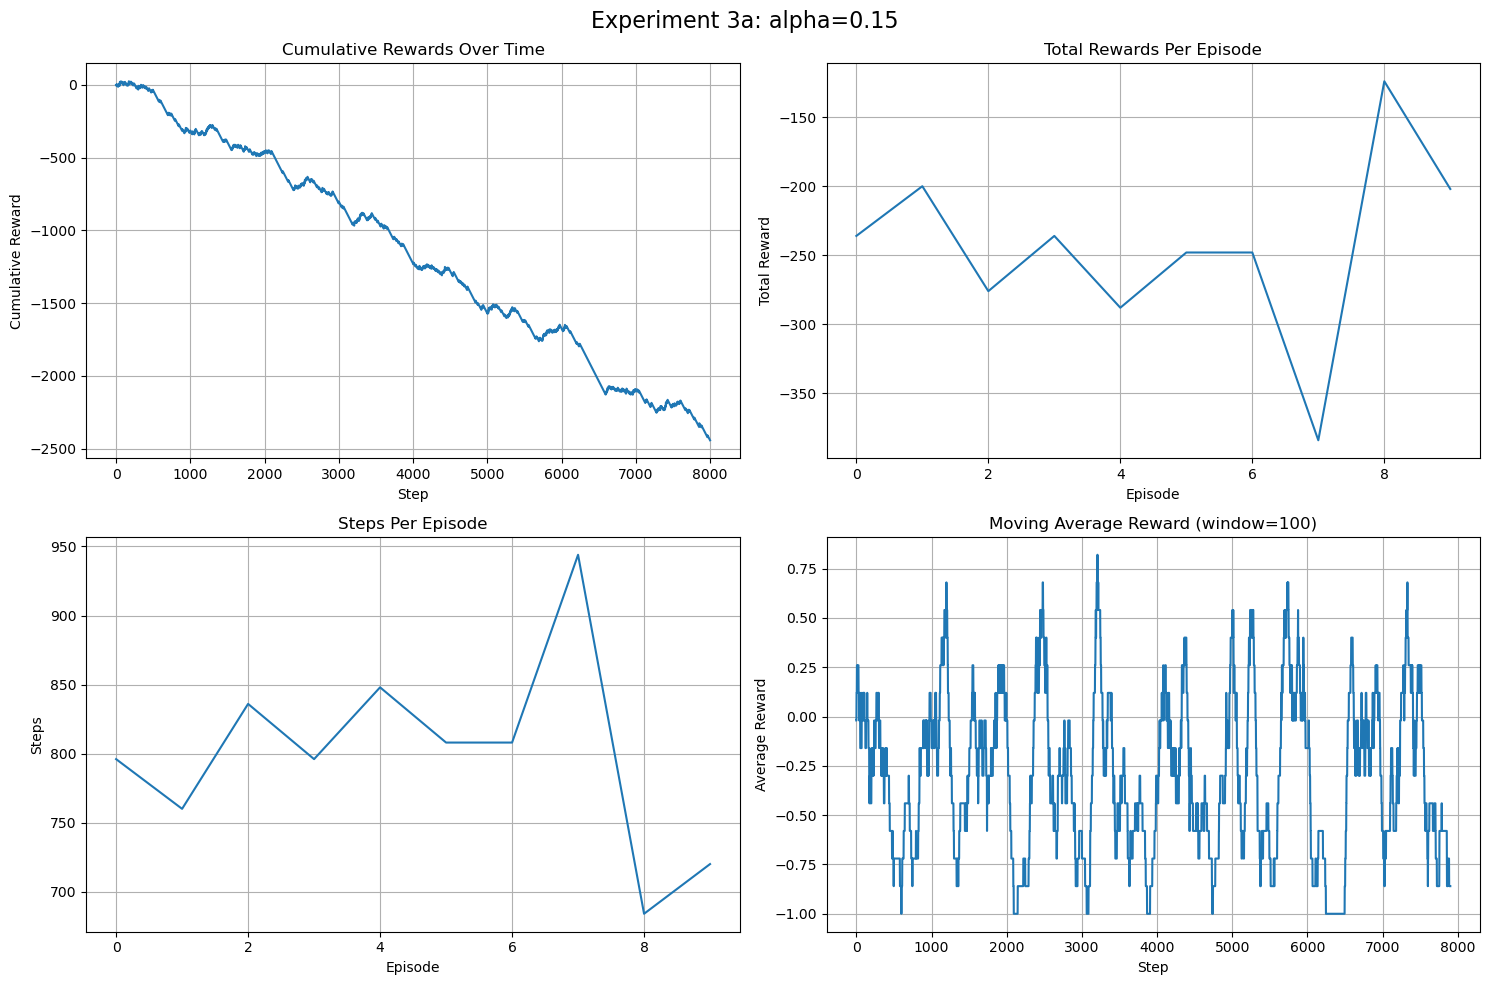



Experiment 3b: Q-learning with alpha=0.45
Running Experiment 3b (alpha=0.45) (Seed: 42)
Saved Q-table snapshots: Experiment_3b_(alpha=0.45)_AgentF_Experiment 3b (alpha=0.45)_first_dropoff5.csv  |  Experiment_3b_(alpha=0.45)_AgentM_Experiment 3b (alpha=0.45)_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_3b_(alpha=0.45)_AgentF_Experiment 3b (alpha=0.45)_first_terminal.csv  |  Experiment_3b_(alpha=0.45)_AgentM_Experiment 3b (alpha=0.45)_first_terminal.csv
Terminal state 1 reached at step 796
Episode steps: 796, Episode reward: -236
Step 1000/8000 - Terminals: 1


Step 2000/8000 - Terminals: 1


Terminal state 2 reached at step 2104
Episode steps: 1308, Episode reward: -748
Step 3000/8000 - Terminals: 2


Terminal state 3 reached at step 3356
Episode steps: 1252, Episode reward: -692
Step 4000/8000 - Terminals: 3


Terminal state 4 reached at step 4228
Episode steps: 872, Episode reward: -312
Terminal state 5 reached at step 4968
Episode

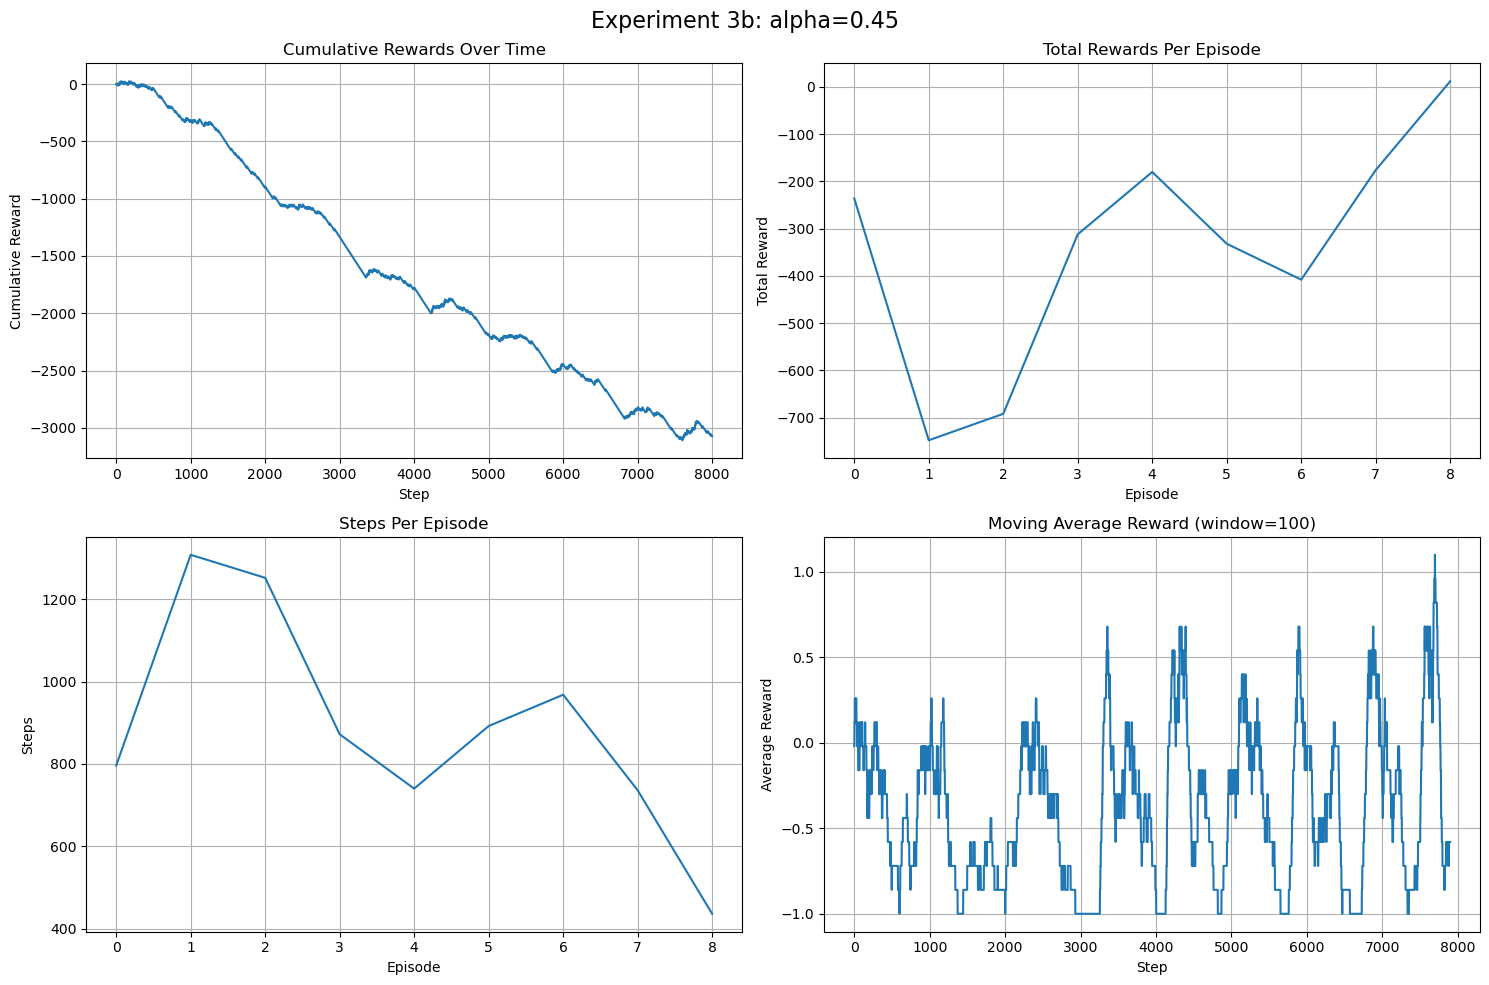

In [31]:
print("Experiment 3a: Q-learning with alpha=0.15")

world_3a = PDWorld()
agent_f_3a = QLearningAgent('F', alpha=0.15, gamma=0.5, algorithm='Q-learning')
agent_m_3a = QLearningAgent('M', alpha=0.15, gamma=0.5, algorithm='Q-learning')

policy_schedule_3 = [(0, 'PRANDOM'), (500, 'PEXPLOIT')]
results_3a = run_experiment(world_3a, agent_f_3a, agent_m_3a, 8000, policy_schedule_3, "Experiment 3a (alpha=0.15)", seed=42)
plot_results(results_3a, "Experiment 3a: alpha=0.15")

print("\n")
print("Experiment 3b: Q-learning with alpha=0.45")

world_3b = PDWorld()
agent_f_3b = QLearningAgent('F', alpha=0.45, gamma=0.5, algorithm='Q-learning')
agent_m_3b = QLearningAgent('M', alpha=0.45, gamma=0.5, algorithm='Q-learning')

results_3b = run_experiment(world_3b, agent_f_3b, agent_m_3b, 8000, policy_schedule_3, "Experiment 3b (alpha=0.45)", seed=42)
plot_results(results_3b, "Experiment 3b: alpha=0.45")

Experiment 4: Pickup locations change after 3rd terminal state
Running Experiment 4 (Seed: 42)
Saved Q-table snapshots: Experiment_4_AgentF_Experiment 4_first_dropoff5.csv  |  Experiment_4_AgentM_Experiment 4_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_4_AgentF_Experiment 4_first_terminal.csv  |  Experiment_4_AgentM_Experiment 4_first_terminal.csv
Terminal state 1 reached at step 796
Episode steps: 796, Episode reward: -236
Step 1000/8000 - Terminals: 1


Step 2000/8000 - Terminals: 1


Terminal state 2 reached at step 2104
Episode steps: 1308, Episode reward: -748
Step 3000/8000 - Terminals: 2


Terminal state 3 reached at step 3360
Episode steps: 1256, Episode reward: -696
Pickup locations changed to: [(1, 2), (4, 5)]
Terminal state 4 reached at step 3972
Episode steps: 612, Episode reward: -52
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4844
Episode steps: 872, Episode reward: -312
Step 5000/8000 - Terminals: 

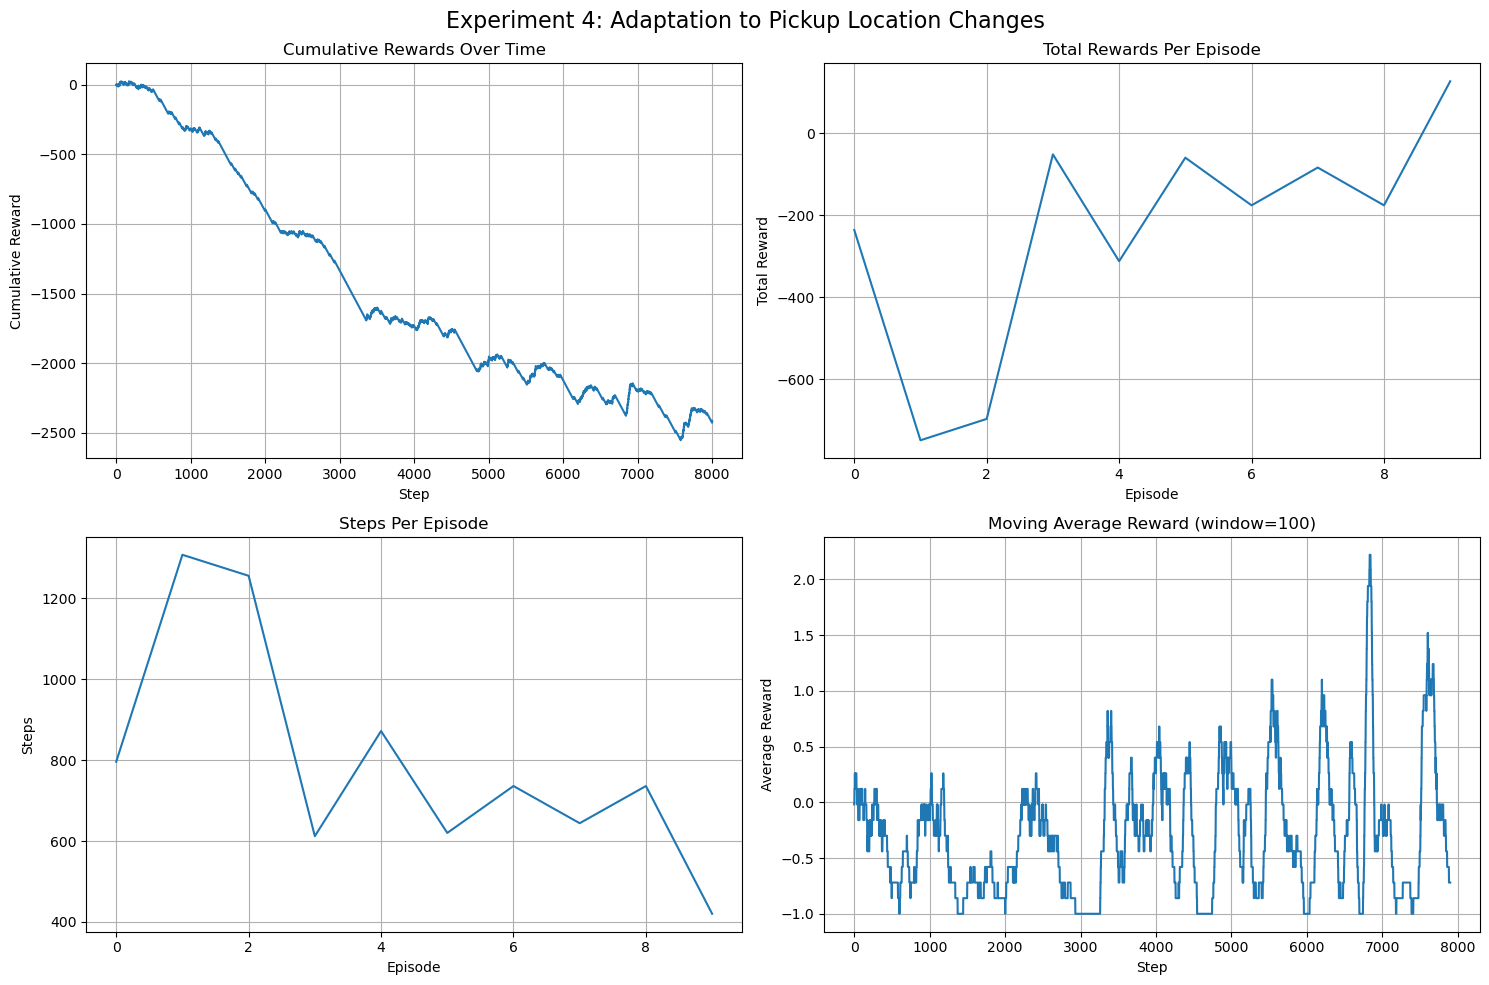

In [32]:
print("Experiment 4: Pickup locations change after 3rd terminal state")

world_4 = PDWorld()
agent_f_4 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_4 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')

policy_schedule_4 = [(0, 'PRANDOM'), (500, 'PEXPLOIT')]
pickup_change = (3, [(1,2), (4,5)])
results_4 = run_experiment(world_4, agent_f_4, agent_m_4, 8000, policy_schedule_4, "Experiment 4", pickup_change_config=pickup_change, seed=42)
plot_results(results_4, "Experiment 4: Adaptation to Pickup Location Changes")

Comparison of All Experiments(Run 1)


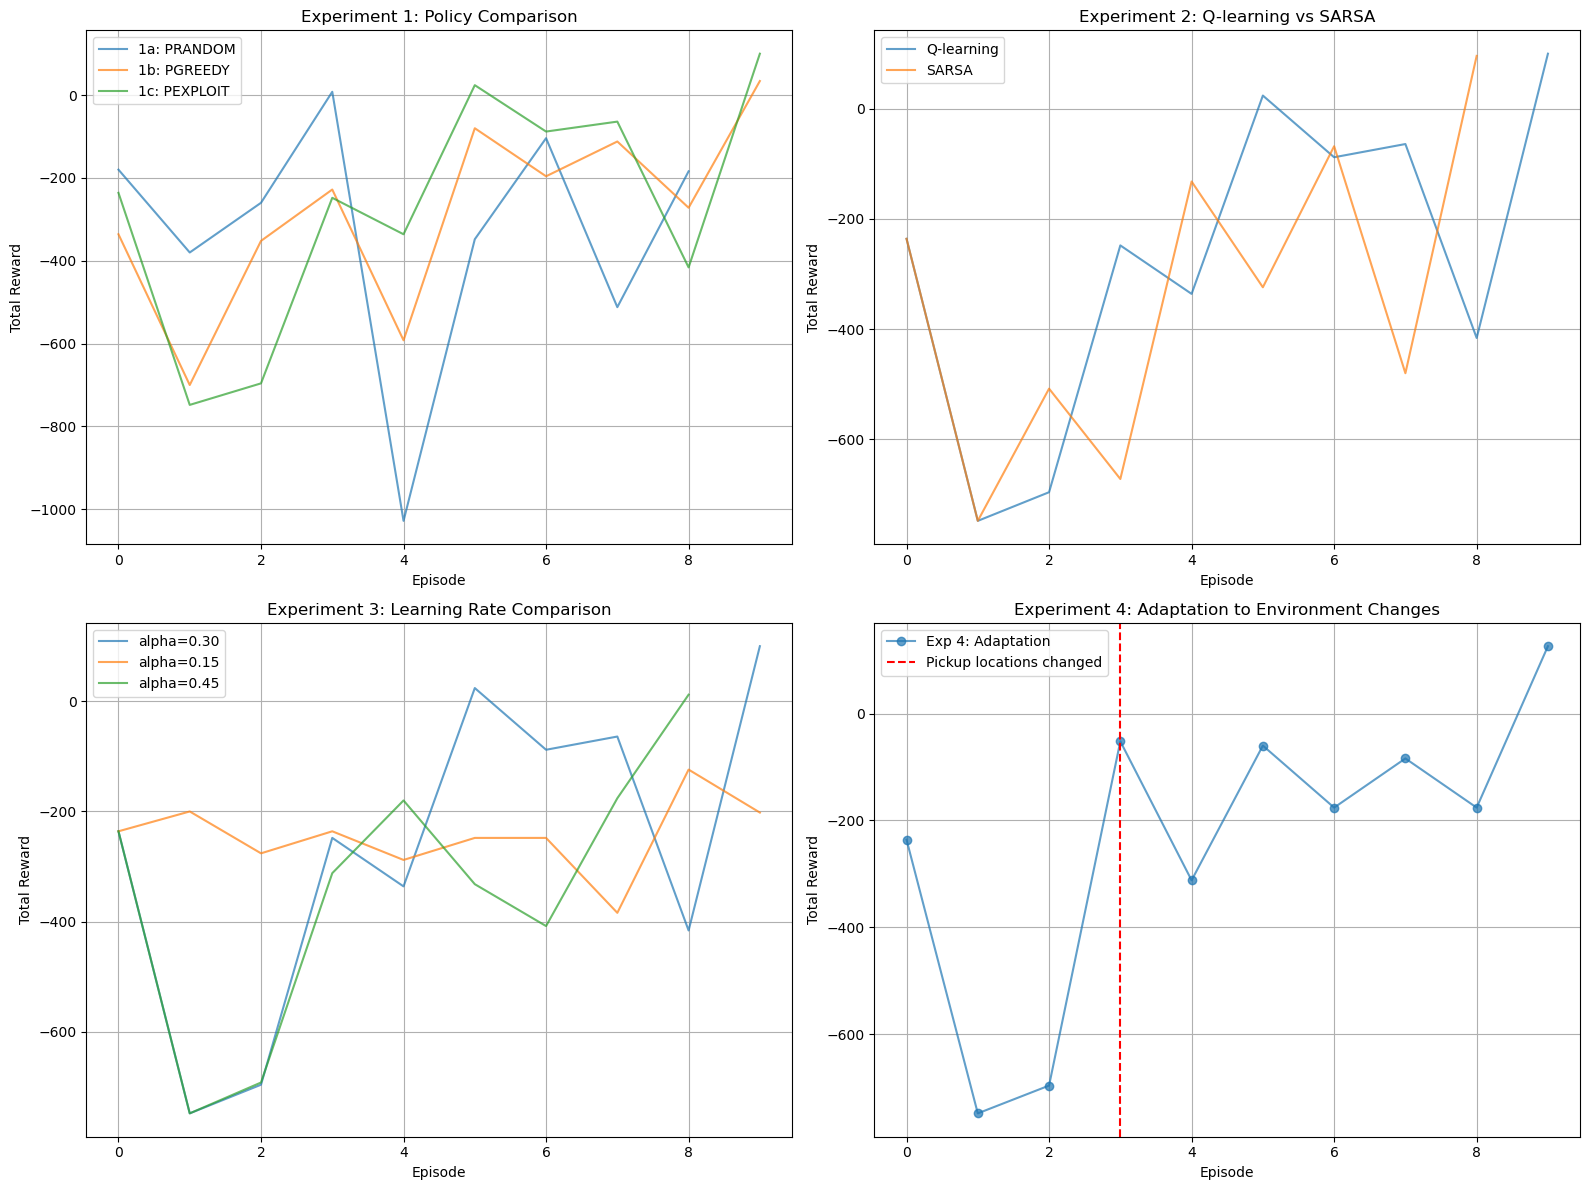


Summary Statistics

1a (PRANDOM):
  Terminal states reached: 8
  Avg steps per episode: 888.89
  Avg reward per episode: -332.00
  Total cumulative reward: -2988.00

1b (PGREEDY):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per episode: -283.40
  Total cumulative reward: -2834.00

1c (PEXPLOIT):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per episode: -270.80
  Total cumulative reward: -2708.00

2 (SARSA):
  Terminal states reached: 8
  Avg steps per episode: 888.89
  Avg reward per episode: -341.33
  Total cumulative reward: -3072.00

3a (alpha=0.15):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per episode: -244.20
  Total cumulative reward: -2442.00

3b (alpha=0.45):
  Terminal states reached: 8
  Avg steps per episode: 888.89
  Avg reward per episode: -341.33
  Total cumulative reward: -3072.00

4 (Adaptation):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per episo

In [33]:
print("Comparison of All Experiments(Run 1)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]

if results_1a['total_rewards_per_episode']:
    ax1.plot(results_1a['total_rewards_per_episode'], label='1a: PRANDOM', alpha=0.7)
if results_1b['total_rewards_per_episode']:
    ax1.plot(results_1b['total_rewards_per_episode'], label='1b: PGREEDY', alpha=0.7)
if results_1c['total_rewards_per_episode']:
    ax1.plot(results_1c['total_rewards_per_episode'], label='1c: PEXPLOIT', alpha=0.7)

ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Experiment 1: Policy Comparison')
ax1.legend()
ax1.grid(True)

ax2 = axes[0, 1]

if results_1c['total_rewards_per_episode']:
    ax2.plot(results_1c['total_rewards_per_episode'], label='Q-learning', alpha=0.7)
if results_2['total_rewards_per_episode']:
    ax2.plot(results_2['total_rewards_per_episode'], label='SARSA', alpha=0.7)

ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Reward')
ax2.set_title('Experiment 2: Q-learning vs SARSA')

ax2.legend()
ax2.grid(True)

ax3 = axes[1, 0]
if results_1c['total_rewards_per_episode']:
    ax3.plot(results_1c['total_rewards_per_episode'], label='alpha=0.30', alpha=0.7)
if results_3a['total_rewards_per_episode']:
    ax3.plot(results_3a['total_rewards_per_episode'], label='alpha=0.15', alpha=0.7)
if results_3b['total_rewards_per_episode']:
    ax3.plot(results_3b['total_rewards_per_episode'], label='alpha=0.45', alpha=0.7)

ax3.set_xlabel('Episode')
ax3.set_ylabel('Total Reward')
ax3.set_title('Experiment 3: Learning Rate Comparison')
ax3.legend()

ax3.grid(True)

ax4 = axes[1, 1]
if results_4['total_rewards_per_episode']:
    ax4.plot(results_4['total_rewards_per_episode'], label='Exp 4: Adaptation', alpha=0.7, marker='o')
    ax4.axvline(x=3, color='r', linestyle='--', label='Pickup locations changed')

ax4.set_xlabel('Episode')
ax4.set_ylabel('Total Reward')
ax4.set_title('Experiment 4: Adaptation to Environment Changes')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print("\nSummary Statistics")

experiments = {
    '1a (PRANDOM)': results_1a,
    '1b (PGREEDY)': results_1b,
    '1c (PEXPLOIT)': results_1c,
    '2 (SARSA)': results_2,
    '3a (alpha=0.15)': results_3a,
    '3b (alpha=0.45)': results_3b,
    '4 (Adaptation)': results_4
}

for name, results in experiments.items():
    print(f"\n{name}:")
    print(f"  Terminal states reached: {results['terminal_count']}")
    if results['steps_per_episode']:
        print(f"  Avg steps per episode: {np.mean(results['steps_per_episode']):.2f}")
        print(f"  Avg reward per episode: {np.mean(results['total_rewards_per_episode']):.2f}")
    print(f"  Total cumulative reward: {sum(results['rewards_history']):.2f}")

Running experiments again with different random seed for comparison
Running Experiment 1a Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_1a_Run_2_AgentF_Experiment 1a Run 2_first_dropoff5.csv  |  Experiment_1a_Run_2_AgentM_Experiment 1a Run 2_first_dropoff5.csv
Saved Q-table snapshots: Experiment_1a_Run_2_AgentF_Experiment 1a Run 2_first_terminal.csv  |  Experiment_1a_Run_2_AgentM_Experiment 1a Run 2_first_terminal.csv
Terminal state 1 reached at step 568
Episode steps: 568, Episode reward: -8
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1512
Episode steps: 944, Episode reward: -384
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2428
Episode steps: 916, Episode reward: -356
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3236
Episode steps: 808, Episode reward: -248
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4056
Episode steps: 820, Episode reward: -260
Step 5000/8000 - Terminals: 5


Terminal state 6 r

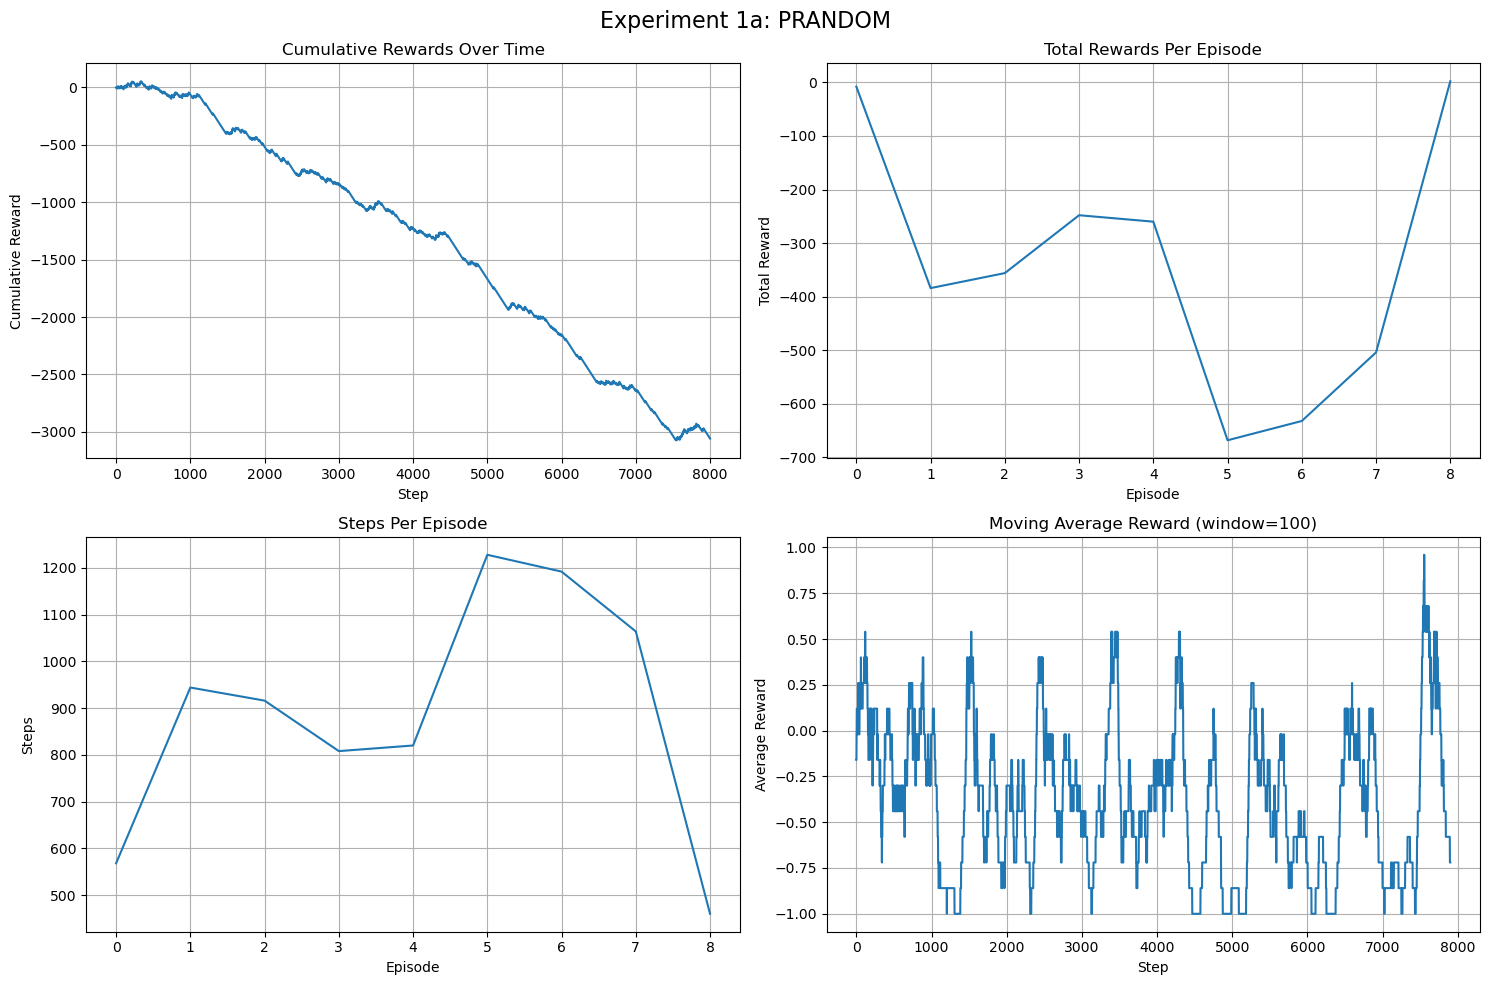

Running Experiment 1b Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_1b_Run_2_AgentF_Experiment 1b Run 2_first_dropoff5.csv  |  Experiment_1b_Run_2_AgentM_Experiment 1b Run 2_first_dropoff5.csv

Switching to policy PGREEDY at step 500
Saved Q-table snapshots: Experiment_1b_Run_2_AgentF_Experiment 1b Run 2_first_terminal.csv  |  Experiment_1b_Run_2_AgentM_Experiment 1b Run 2_first_terminal.csv
Terminal state 1 reached at step 600
Episode steps: 600, Episode reward: -40
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1296
Episode steps: 696, Episode reward: -136
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2284
Episode steps: 988, Episode reward: -428
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3380
Episode steps: 1096, Episode reward: -536
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4116
Episode steps: 736, Episode reward: -176
Step 5000/8000 - Terminals: 5


Terminal state 6 reached at step 5020
Episo

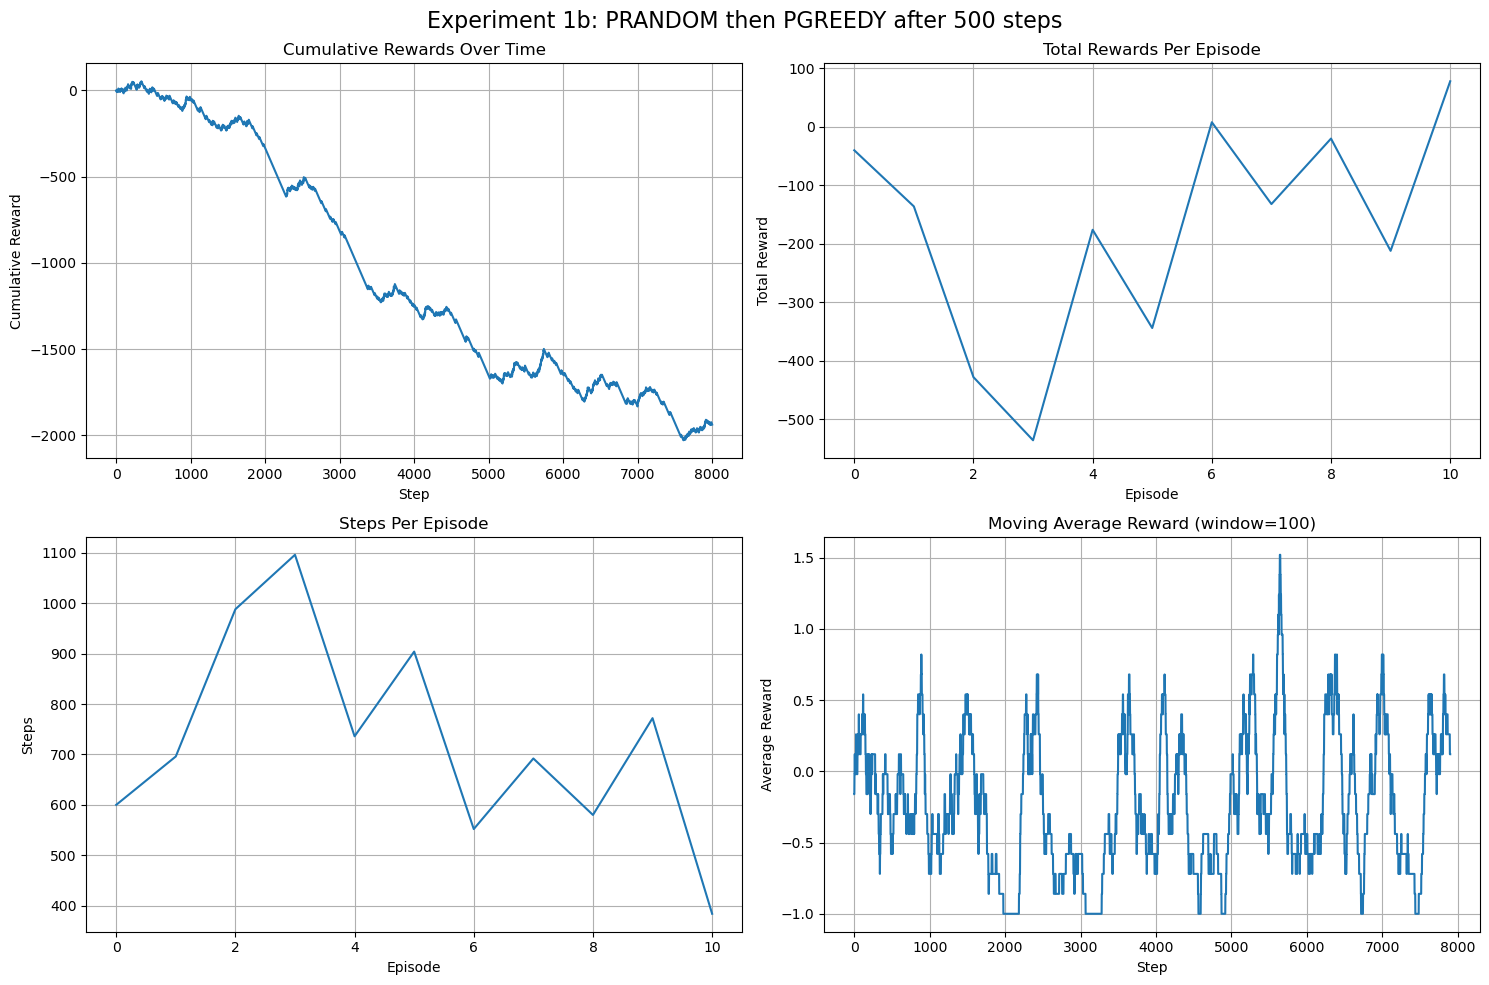

Running Experiment 1c Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_1c_Run_2_AgentF_Experiment 1c Run 2_first_dropoff5.csv  |  Experiment_1c_Run_2_AgentM_Experiment 1c Run 2_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_1c_Run_2_AgentF_Experiment 1c Run 2_first_terminal.csv  |  Experiment_1c_Run_2_AgentM_Experiment 1c Run 2_first_terminal.csv
Terminal state 1 reached at step 640
Episode steps: 640, Episode reward: -80
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1472
Episode steps: 832, Episode reward: -272
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2492
Episode steps: 1020, Episode reward: -460
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3104
Episode steps: 612, Episode reward: -52
Terminal state 5 reached at step 3820
Episode steps: 716, Episode reward: -156
Step 4000/8000 - Terminals: 5


Terminal state 6 reached at step 4496
Episode steps: 676, Episode reward: -

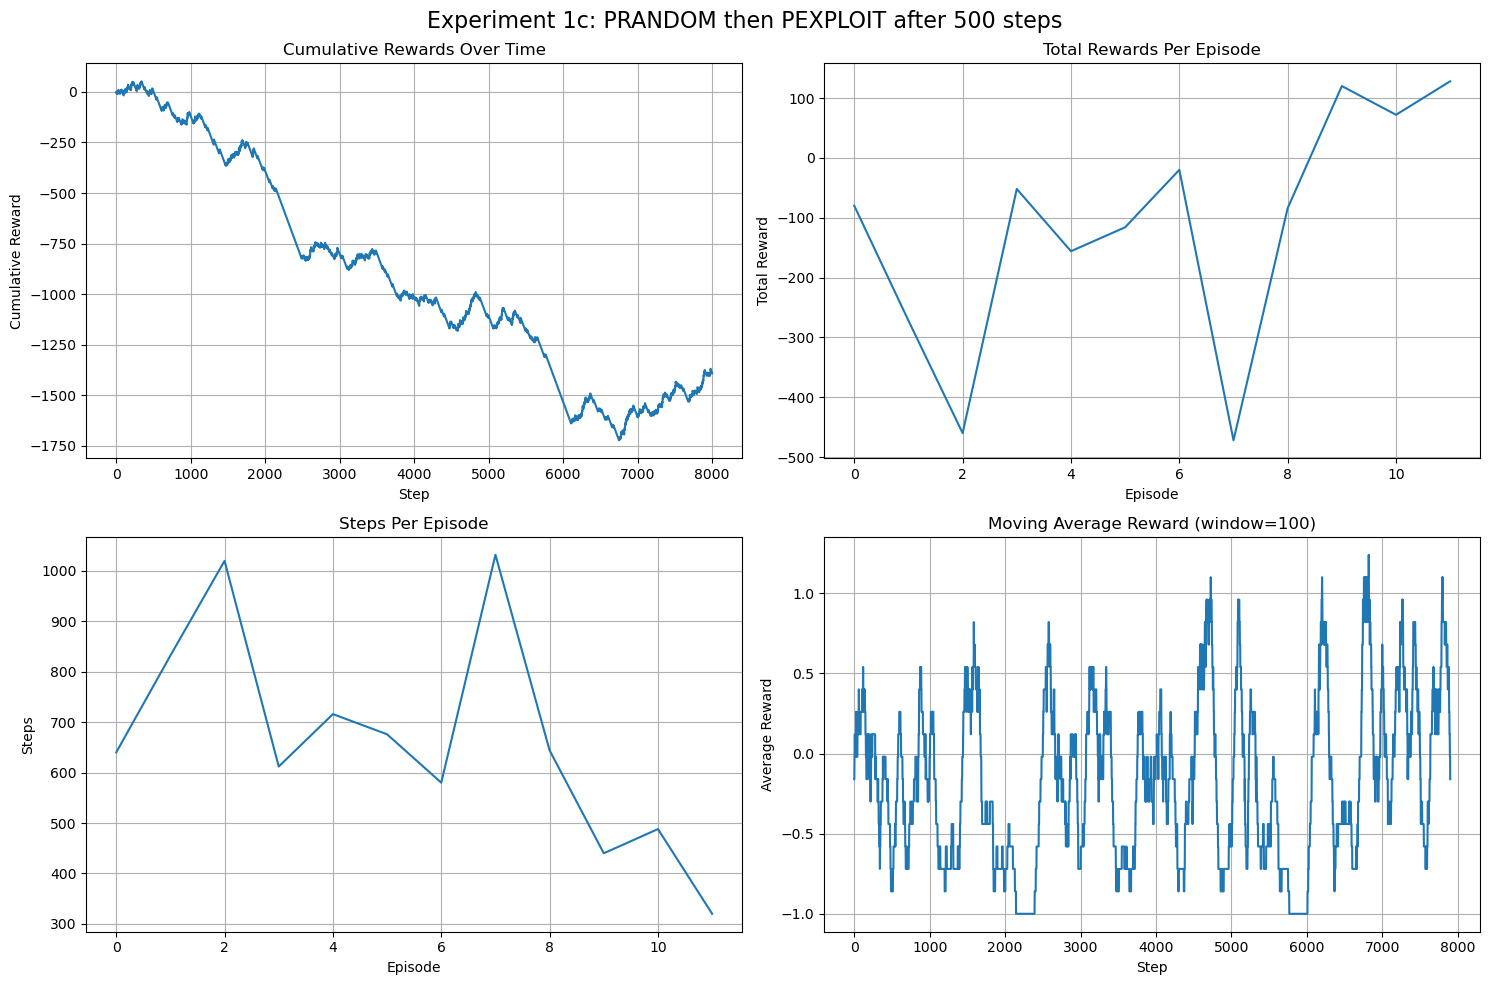

Running Experiment 2 Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_2_Run_2_AgentF_Experiment 2 Run 2_first_dropoff5.csv  |  Experiment_2_Run_2_AgentM_Experiment 2 Run 2_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_2_Run_2_AgentF_Experiment 2 Run 2_first_terminal.csv  |  Experiment_2_Run_2_AgentM_Experiment 2 Run 2_first_terminal.csv
Terminal state 1 reached at step 640
Episode steps: 640, Episode reward: -80
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1472
Episode steps: 832, Episode reward: -272
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2420
Episode steps: 948, Episode reward: -388
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3512
Episode steps: 1092, Episode reward: -532
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4348
Episode steps: 836, Episode reward: -276
Terminal state 6 reached at step 4932
Episode steps: 584, Episode reward: -24
Step 

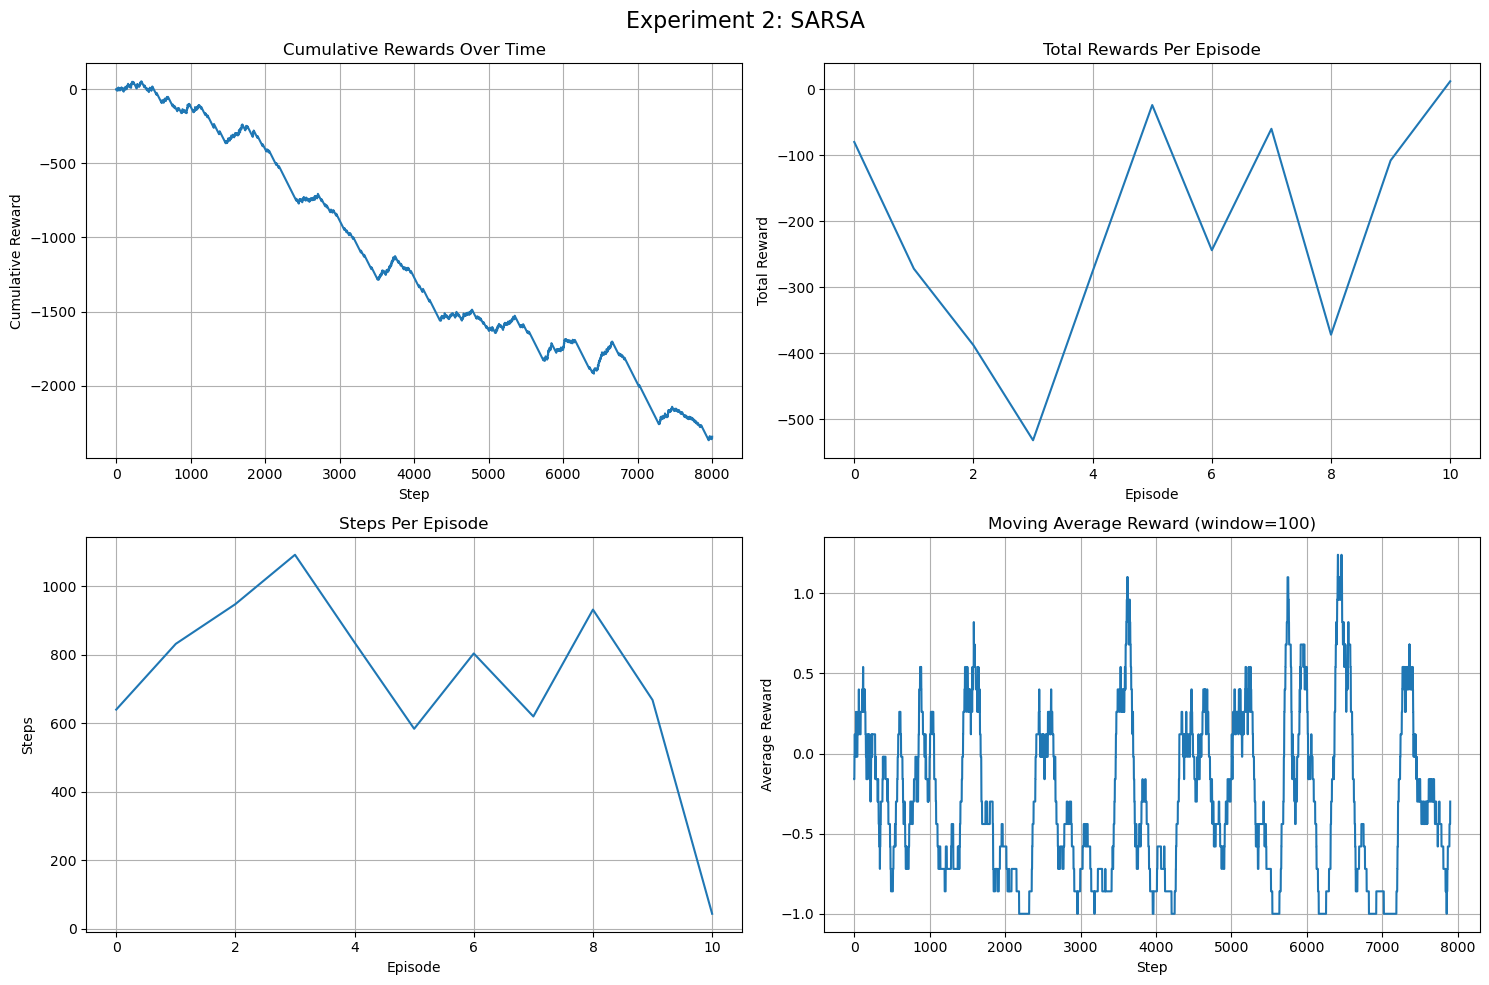

Running Experiment 3a Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_3a_Run_2_AgentF_Experiment 3a Run 2_first_dropoff5.csv  |  Experiment_3a_Run_2_AgentM_Experiment 3a Run 2_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_3a_Run_2_AgentF_Experiment 3a Run 2_first_terminal.csv  |  Experiment_3a_Run_2_AgentM_Experiment 3a Run 2_first_terminal.csv
Terminal state 1 reached at step 640
Episode steps: 640, Episode reward: -80
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1624
Episode steps: 984, Episode reward: -424
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2380
Episode steps: 756, Episode reward: -196
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3384
Episode steps: 1004, Episode reward: -444
Step 4000/8000 - Terminals: 4


Terminal state 5 reached at step 4064
Episode steps: 680, Episode reward: -120
Terminal state 6 reached at step 4728
Episode steps: 664, Episode reward: 

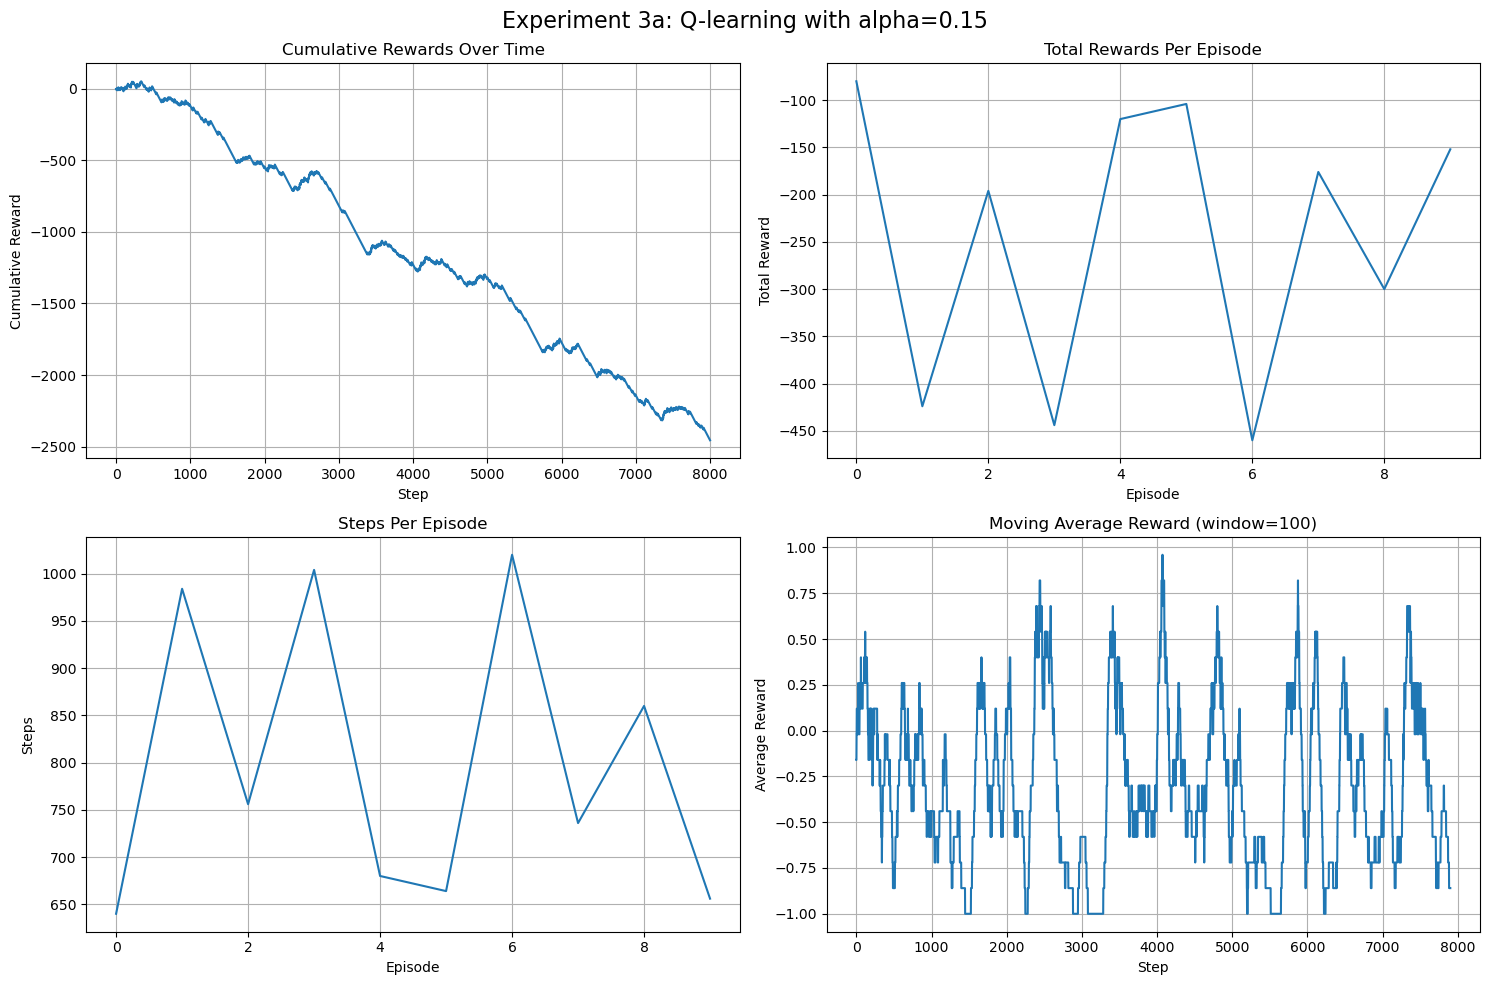

Running Experiment 3b Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_3b_Run_2_AgentF_Experiment 3b Run 2_first_dropoff5.csv  |  Experiment_3b_Run_2_AgentM_Experiment 3b Run 2_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_3b_Run_2_AgentF_Experiment 3b Run 2_first_terminal.csv  |  Experiment_3b_Run_2_AgentM_Experiment 3b Run 2_first_terminal.csv
Terminal state 1 reached at step 640
Episode steps: 640, Episode reward: -80
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1472
Episode steps: 832, Episode reward: -272
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2492
Episode steps: 1020, Episode reward: -460
Step 3000/8000 - Terminals: 3


Terminal state 4 reached at step 3228
Episode steps: 736, Episode reward: -176
Terminal state 5 reached at step 3996
Episode steps: 768, Episode reward: -208
Step 4000/8000 - Terminals: 5


Terminal state 6 reached at step 4788
Episode steps: 792, Episode reward: 

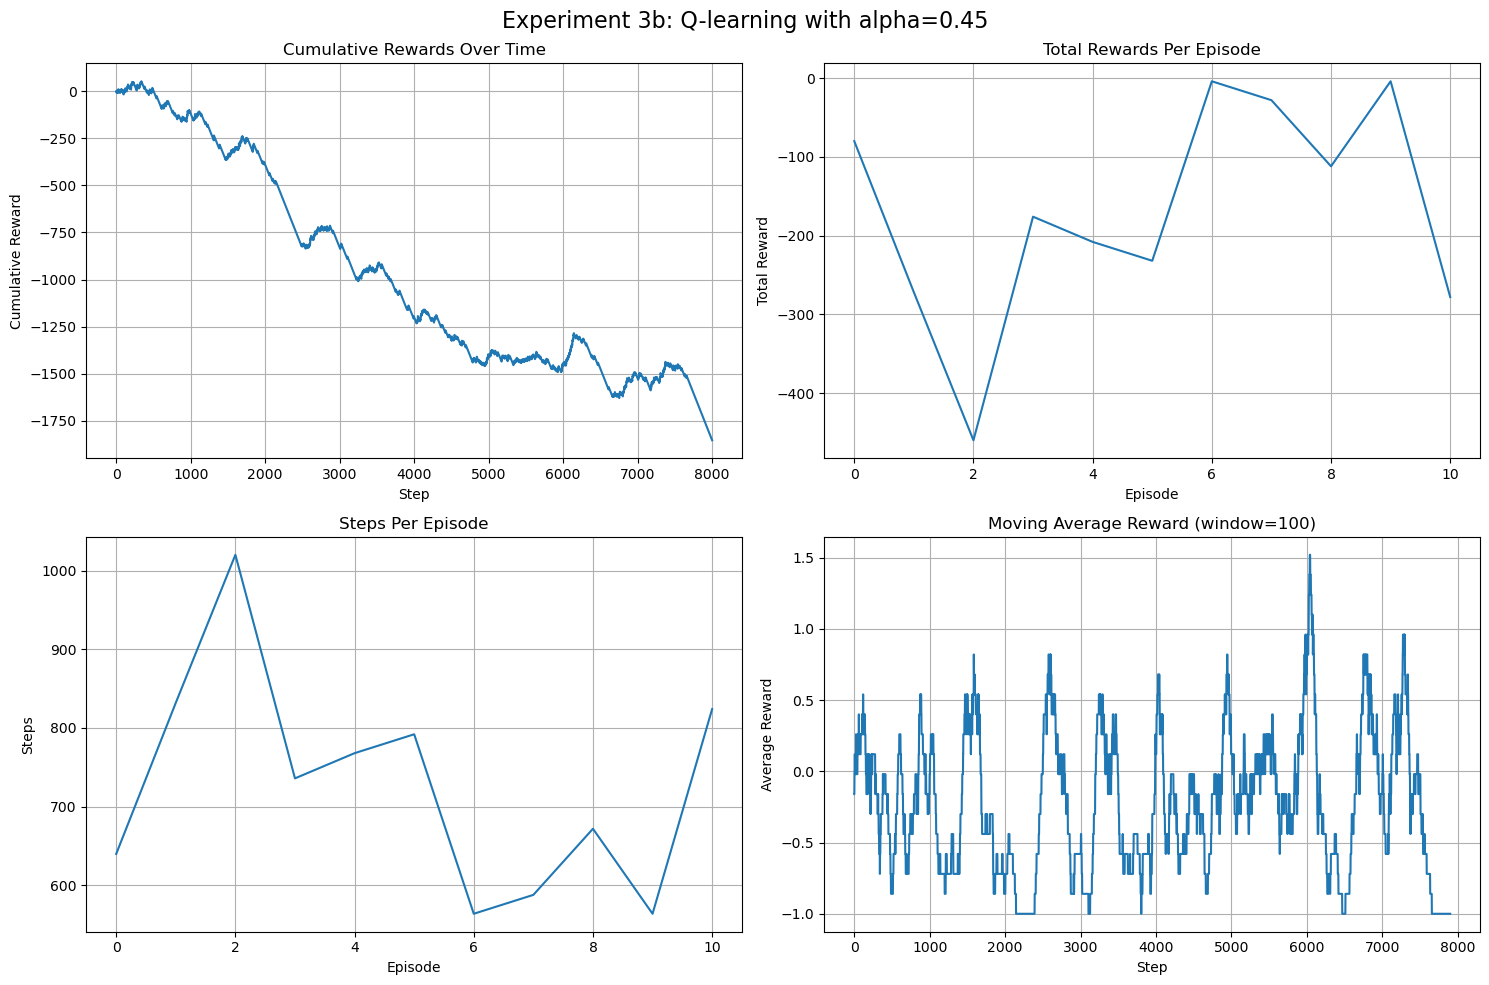

Running Experiment 4 Run 2 (Seed: 999)
Saved Q-table snapshots: Experiment_4_Run_2_AgentF_Experiment 4 Run 2_first_dropoff5.csv  |  Experiment_4_Run_2_AgentM_Experiment 4 Run 2_first_dropoff5.csv

Switching to policy PEXPLOIT at step 500
Saved Q-table snapshots: Experiment_4_Run_2_AgentF_Experiment 4 Run 2_first_terminal.csv  |  Experiment_4_Run_2_AgentM_Experiment 4 Run 2_first_terminal.csv
Terminal state 1 reached at step 640
Episode steps: 640, Episode reward: -80
Step 1000/8000 - Terminals: 1


Terminal state 2 reached at step 1472
Episode steps: 832, Episode reward: -272
Step 2000/8000 - Terminals: 2


Terminal state 3 reached at step 2492
Episode steps: 1020, Episode reward: -460
Pickup locations changed to: [(1, 2), (4, 5)]
Step 3000/8000 - Terminals: 3


Step 4000/8000 - Terminals: 3


Terminal state 4 reached at step 4000
Episode steps: 1508, Episode reward: -948
Terminal state 5 reached at step 4944
Episode steps: 944, Episode reward: -384
Step 5000/8000 - Terminals: 5


Term

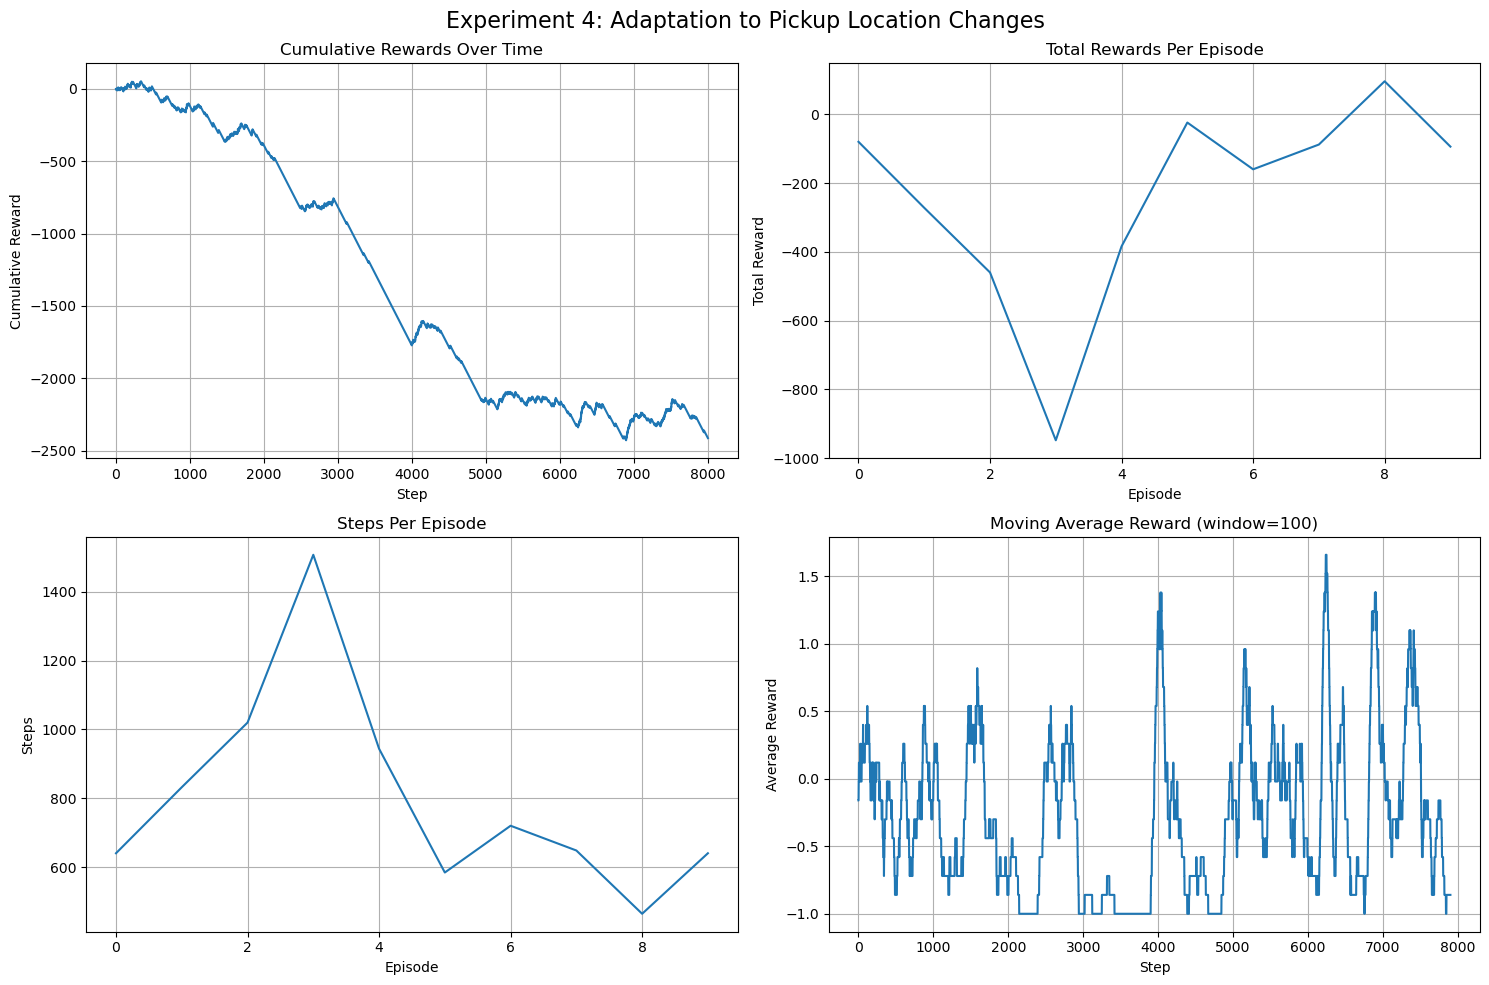



Compare: Run 1 vs Run 2

1a (PRANDOM):
  Run 1 - Terminals: 8, Avg reward: -332.00
  Run 2 - Terminals: 8, Avg reward: -339.78

1b (PGREEDY):
  Run 1 - Terminals: 9, Avg reward: -283.40
  Run 2 - Terminals: 10, Avg reward: -176.18

1c (PEXPLOIT):
  Run 1 - Terminals: 9, Avg reward: -270.80
  Run 2 - Terminals: 11, Avg reward: -116.00

2 (SARSA):
  Run 1 - Terminals: 8, Avg reward: -341.33
  Run 2 - Terminals: 10, Avg reward: -213.09

3a (alpha=0.15):
  Run 1 - Terminals: 9, Avg reward: -244.20
  Run 2 - Terminals: 9, Avg reward: -245.60

3b (alpha=0.45):
  Run 1 - Terminals: 8, Avg reward: -341.33
  Run 2 - Terminals: 10, Avg reward: -168.55

4 (Adaptation):
  Run 1 - Terminals: 9, Avg reward: -241.40
  Run 2 - Terminals: 9, Avg reward: -241.40


In [34]:
print("Running experiments again with different random seed for comparison")

world_1a_r2 = PDWorld()
agent_f_1a_r2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1a_r2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')
results_1a_r2 = run_experiment(world_1a_r2, agent_f_1a_r2, agent_m_1a_r2, 8000, policy_schedule_1a, "Experiment 1a Run 2", seed=999)
plot_results(results_1a_r2, "Experiment 1a: PRANDOM")

world_1b_r2 = PDWorld()
agent_f_1b_r2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1b_r2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')
results_1b_r2 = run_experiment(world_1b_r2, agent_f_1b_r2, agent_m_1b_r2, 8000, policy_schedule_1b, "Experiment 1b Run 2", seed=999)
plot_results(results_1b_r2, "Experiment 1b: PRANDOM then PGREEDY after 500 steps")

world_1c_r2 = PDWorld()
agent_f_1c_r2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_1c_r2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')
results_1c_r2 = run_experiment(world_1c_r2, agent_f_1c_r2, agent_m_1c_r2, 8000, policy_schedule_1c, "Experiment 1c Run 2", seed=999)
plot_results(results_1c_r2, "Experiment 1c: PRANDOM then PEXPLOIT after 500 steps")

world_2_r2 = PDWorld()
agent_f_2_r2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='SARSA')
agent_m_2_r2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='SARSA')
results_2_r2 = run_experiment(world_2_r2, agent_f_2_r2, agent_m_2_r2, 8000, policy_schedule_2, "Experiment 2 Run 2", seed=999)
plot_results(results_2_r2, "Experiment 2: SARSA")

world_3a_r2 = PDWorld()
agent_f_3a_r2 = QLearningAgent('F', alpha=0.15, gamma=0.5, algorithm='Q-learning')
agent_m_3a_r2 = QLearningAgent('M', alpha=0.15, gamma=0.5, algorithm='Q-learning')
results_3a_r2 = run_experiment(world_3a_r2, agent_f_3a_r2, agent_m_3a_r2, 8000, policy_schedule_3, "Experiment 3a Run 2", seed=999)
plot_results(results_3a_r2, "Experiment 3a: Q-learning with alpha=0.15")

world_3b_r2 = PDWorld()
agent_f_3b_r2 = QLearningAgent('F', alpha=0.45, gamma=0.5, algorithm='Q-learning')
agent_m_3b_r2 = QLearningAgent('M', alpha=0.45, gamma=0.5, algorithm='Q-learning')
results_3b_r2 = run_experiment(world_3b_r2, agent_f_3b_r2, agent_m_3b_r2, 8000, policy_schedule_3, "Experiment 3b Run 2", seed=999)
plot_results(results_3b_r2, "Experiment 3b: Q-learning with alpha=0.45")

world_4_r2 = PDWorld()
agent_f_4_r2 = QLearningAgent('F', alpha=0.3, gamma=0.5, algorithm='Q-learning')
agent_m_4_r2 = QLearningAgent('M', alpha=0.3, gamma=0.5, algorithm='Q-learning')
results_4_r2 = run_experiment(world_4_r2, agent_f_4_r2, agent_m_4_r2, 8000, policy_schedule_4, "Experiment 4 Run 2", pickup_change_config=pickup_change, seed=999)
plot_results(results_4_r2, "Experiment 4: Adaptation to Pickup Location Changes")

print("\n")
print("Compare: Run 1 vs Run 2")

comparisons = [
    ("1a (PRANDOM)", results_1a, results_1a_r2),
    ("1b (PGREEDY)", results_1b, results_1b_r2),
    ("1c (PEXPLOIT)", results_1c, results_1c_r2),
    ("2 (SARSA)", results_2, results_2_r2),
    ("3a (alpha=0.15)", results_3a, results_3a_r2),
    ("3b (alpha=0.45)", results_3b, results_3b_r2),
    ("4 (Adaptation)", results_4, results_4_r2)
]

for name, run1, run2 in comparisons:
    print(f"\n{name}:")
    print(f"  Run 1 - Terminals: {run1['terminal_count']}, Avg reward: {np.mean(run1['total_rewards_per_episode']) if run1['total_rewards_per_episode'] else 0:.2f}")
    print(f"  Run 2 - Terminals: {run2['terminal_count']}, Avg reward: {np.mean(run2['total_rewards_per_episode']) if run2['total_rewards_per_episode'] else 0:.2f}")

Comparison of All Experiments(Run 2)


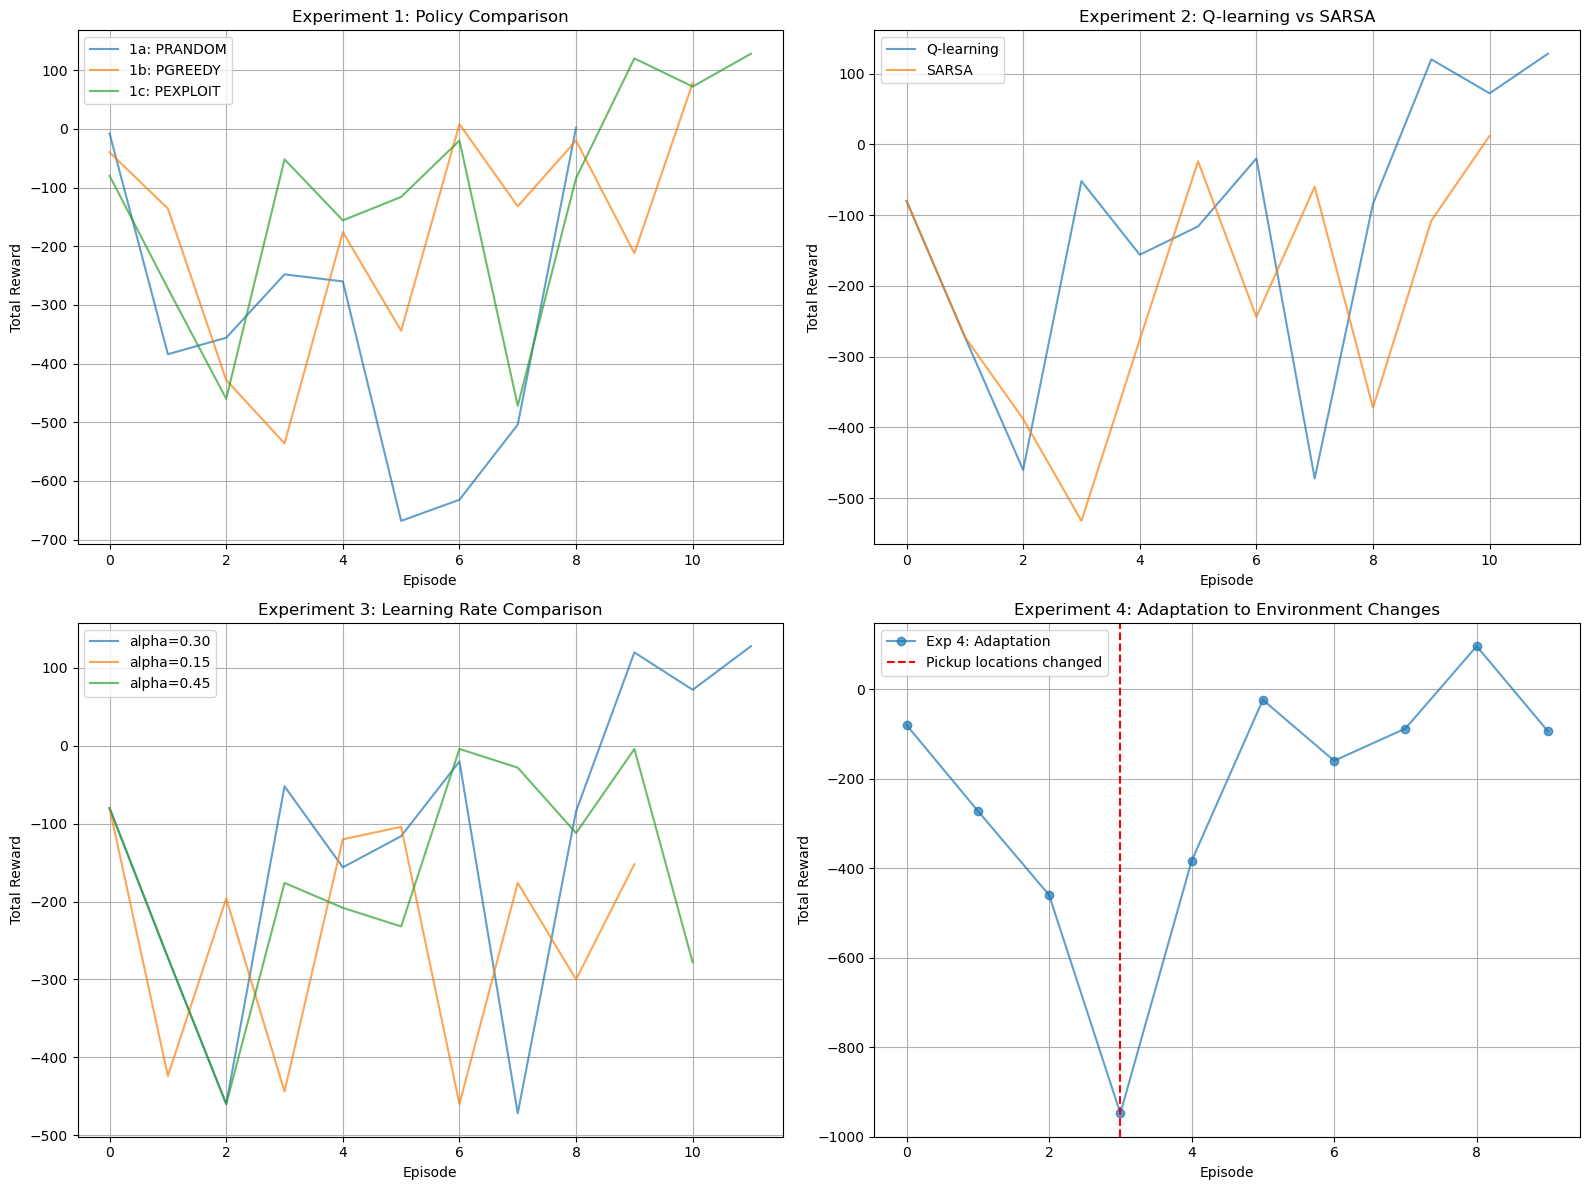


Summary Statistics

1a (PRANDOM):
  Terminal states reached: 8
  Avg steps per episode: 888.89
  Avg reward per episode: -339.78
  Total cumulative reward: -3058.00

1b (PGREEDY):
  Terminal states reached: 10
  Avg steps per episode: 727.27
  Avg reward per episode: -176.18
  Total cumulative reward: -1938.00

1c (PEXPLOIT):
  Terminal states reached: 11
  Avg steps per episode: 666.67
  Avg reward per episode: -116.00
  Total cumulative reward: -1392.00

2 (SARSA):
  Terminal states reached: 10
  Avg steps per episode: 727.27
  Avg reward per episode: -213.09
  Total cumulative reward: -2344.00

3a (alpha=0.15):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per episode: -245.60
  Total cumulative reward: -2456.00

3b (alpha=0.45):
  Terminal states reached: 10
  Avg steps per episode: 727.27
  Avg reward per episode: -168.55
  Total cumulative reward: -1854.00

4 (Adaptation):
  Terminal states reached: 9
  Avg steps per episode: 800.00
  Avg reward per e

In [35]:
print("Comparison of All Experiments(Run 2)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]

if results_1a_r2['total_rewards_per_episode']:
    ax1.plot(results_1a_r2['total_rewards_per_episode'], label='1a: PRANDOM', alpha=0.7)
if results_1b_r2['total_rewards_per_episode']:
    ax1.plot(results_1b_r2['total_rewards_per_episode'], label='1b: PGREEDY', alpha=0.7)
if results_1c_r2['total_rewards_per_episode']:
    ax1.plot(results_1c_r2['total_rewards_per_episode'], label='1c: PEXPLOIT', alpha=0.7)

ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Experiment 1: Policy Comparison')
ax1.legend()
ax1.grid(True)

ax2 = axes[0, 1]

if results_1c_r2['total_rewards_per_episode']:
    ax2.plot(results_1c_r2['total_rewards_per_episode'], label='Q-learning', alpha=0.7)
if results_2_r2['total_rewards_per_episode']:
    ax2.plot(results_2_r2['total_rewards_per_episode'], label='SARSA', alpha=0.7)

ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Reward')
ax2.set_title('Experiment 2: Q-learning vs SARSA')

ax2.legend()
ax2.grid(True)

ax3 = axes[1, 0]
if results_1c_r2['total_rewards_per_episode']:
    ax3.plot(results_1c_r2['total_rewards_per_episode'], label='alpha=0.30', alpha=0.7)
if results_3a_r2['total_rewards_per_episode']:
    ax3.plot(results_3a_r2['total_rewards_per_episode'], label='alpha=0.15', alpha=0.7)
if results_3b_r2['total_rewards_per_episode']:
    ax3.plot(results_3b_r2['total_rewards_per_episode'], label='alpha=0.45', alpha=0.7)

ax3.set_xlabel('Episode')
ax3.set_ylabel('Total Reward')
ax3.set_title('Experiment 3: Learning Rate Comparison')
ax3.legend()

ax3.grid(True)

ax4 = axes[1, 1]
if results_4_r2['total_rewards_per_episode']:
    ax4.plot(results_4_r2['total_rewards_per_episode'], label='Exp 4: Adaptation', alpha=0.7, marker='o')
    ax4.axvline(x=3, color='r', linestyle='--', label='Pickup locations changed')

ax4.set_xlabel('Episode')
ax4.set_ylabel('Total Reward')
ax4.set_title('Experiment 4: Adaptation to Environment Changes')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print("\nSummary Statistics")

experiments = {
    '1a (PRANDOM)': results_1a_r2,
    '1b (PGREEDY)': results_1b_r2,
    '1c (PEXPLOIT)': results_1c_r2,
    '2 (SARSA)': results_2_r2,
    '3a (alpha=0.15)': results_3a_r2,
    '3b (alpha=0.45)': results_3b_r2,
    '4 (Adaptation)': results_4_r2
}

for name, results in experiments.items():
    print(f"\n{name}:")
    print(f"  Terminal states reached: {results['terminal_count']}")
    if results['steps_per_episode']:
        print(f"  Avg steps per episode: {np.mean(results['steps_per_episode']):.2f}")
        print(f"  Avg reward per episode: {np.mean(results['total_rewards_per_episode']):.2f}")
    print(f"  Total cumulative reward: {sum(results['rewards_history']):.2f}")

In [36]:
print("Coordination between agents in Exp. 1b and 1c:")
print(f"  Experiment 1b - Mean Agent Distance per Episode: {results_1b_r2['mean_agent_distance']:.2f}")
print(f"  Experiment 1c - Mean Agent Distance per Episode: {results_1c_r2['mean_agent_distance']:.2f}")

Coordination between agents in Exp. 1b and 1c:
  Experiment 1b - Mean Agent Distance per Episode: 3.18
  Experiment 1c - Mean Agent Distance per Episode: 3.27


In [37]:
print("Expiremtnt 1c Final Q-Table:")
snap_1c_r2_final = results_1c_r2['qtable_snapshots']['final']

print("\nFinal Q-Table (F):")
print(snap_1c_r2_final['F'].head(12).to_string(index=False))

print("\nFinal Q-Table (M):")
print(snap_1c_r2_final['M'].head(12).to_string(index=False))

Expiremtnt 1c Final Q-Table:

Final Q-Table (F):
                  state    N        S         E         W
((1, 3), False, (5, 3))  0.0 -0.83193 -0.882351 -0.882351
((1, 2), False, (5, 3))  0.0  0.00000 -0.413985 -0.755550
((1, 2), False, (5, 2))  0.0  0.00000 -0.300000 -0.510000
((1, 1), False, (5, 2))  0.0 -0.51000 -0.510000  0.000000
((1, 1), False, (5, 3))  0.0 -0.30000 -0.300000  0.000000
((1, 1), False, (4, 2))  0.0 -0.59325 -0.300000  0.000000
((1, 2), False, (4, 2))  0.0 -0.65700 -0.657000 -0.733500
((1, 1), False, (4, 1))  0.0 -0.65700 -0.657000  0.000000
((1, 2), False, (4, 1))  0.0  0.00000 -0.300000 -0.345000
((1, 2), False, (5, 1))  0.0 -0.51000 -0.510000  0.000000
((2, 2), False, (5, 1))  0.0  0.00000  0.000000  0.000000
((2, 2), False, (4, 1)) -0.3 -0.51000 -0.300000 -0.300000

Final Q-Table (M):
                  state      N      S     E      W
((5, 3), False, (1, 2)) -0.657  0.000 -0.51 -0.657
((5, 2), False, (1, 2))  0.000  0.000  0.00  0.000
((5, 2), False, (1, 1)) 

In [38]:
snap_2_r2 = results_2_r2['qtable_snapshots']

print("\nQ-Table at first drop-off filled (F):")
print(snap_2_r2['first_dropoff_5']['F'].head(12).to_string(index=False))
print("\nQ-Table at first drop-off filled (M):")
print(snap_2_r2['first_dropoff_5']['M'].head(12).to_string(index=False))

print("\nQ-Table at first terminal (F):")
print(snap_2_r2['first_terminal']['F'].head(12).to_string(index=False))
print("\nQ-Table at first terminal (M):")
print(snap_2_r2['first_terminal']['M'].head(12).to_string(index=False))

print("\nFinal Q-Table (F):")
print(snap_2_r2['final']['F'].head(12).to_string(index=False))
print("\nFinal Q-Table (M):")
print(snap_2_r2['final']['M'].head(12).to_string(index=False))


Q-Table at first drop-off filled (F):
                  state   N    S    E      W
((1, 3), False, (5, 3)) 0.0  0.0  0.0 -0.300
((1, 2), False, (5, 3)) 0.0  0.0  0.0  0.000
((1, 2), False, (5, 2)) 0.0  0.0  0.0 -0.510
((1, 1), False, (5, 2)) 0.0  0.0  0.0  0.000
((1, 1), False, (5, 3)) 0.0  0.0 -0.3  0.000
((1, 1), False, (4, 2)) 0.0  0.0 -0.3  0.000
((1, 2), False, (4, 2)) 0.0  0.0  0.0 -0.345
((1, 1), False, (4, 1)) 0.0  0.0 -0.3  0.000
((1, 2), False, (4, 1)) 0.0  0.0  0.0  0.000
((1, 2), False, (5, 1)) 0.0 -0.3  0.0  0.000
((2, 2), False, (5, 1)) 0.0  0.0  0.0  0.000
((2, 2), False, (4, 1)) 0.0  0.0 -0.3  0.000

Q-Table at first drop-off filled (M):
                  state    N    S    E     W
((5, 3), False, (1, 2))  0.0  0.0  0.0 -0.51
((5, 2), False, (1, 2))  0.0  0.0  0.0  0.00
((5, 2), False, (1, 1)) -0.3  0.0 -0.3  0.00
((5, 3), False, (1, 1))  0.0  0.0  0.0  0.00
((4, 2), False, (1, 1))  0.0  0.0  0.0  0.00
((4, 2), False, (1, 2))  0.0  0.0  0.0  0.00
 ((4, 2), True, (1, 2)